In [1]:
#the code pipeline for the feature extraction for respiratory methods are highly similar with few differences
#below, we show how to extract features for one participant using the thorax RIP raw data

# FEATURE EXTRACTION EXAMPLE FOR ABDOMEN RIP OF A PARTICIPANT

In [2]:
import pandas as pd
#we first read in a data set of one participant as an example
#it contains the raw Thorax RIP data (already inverted around the x axis so the increases represent inspiration)
#it also contains a column called Task_Label_2 which includes our task labels for the procedure

#data can also be read in from other formats as long as it is turned into a pandas dataframe format

#the dataframe should not be datetime indexed. if it is, drop the indexes before following with the next cells
# read the HDF5 file into a DataFrame
df_abdomen = pd.read_hdf('df_abdomen.h5', 'df_abdomen')

# Display the first few rows of the dataframe to check it
df_abdomen

RSP_Raw Task_Label_2
0       -1.445100e+10             
1       -1.445095e+10             
2       -1.445200e+10             
3       -1.445244e+10             
4       -1.445200e+10             
...               ...          ...
1059836 -1.437400e+10         94.0
1059837 -1.437494e+10         94.0
1059838 -1.437400e+10         94.0
1059839 -1.437051e+10         94.0
1059840 -1.437400e+10         94.0

[1059841 rows x 2 columns]

In [3]:
#below, we are customizing the steps of respiration processing and defining the function via neurokit2
#the main steps include cleaning and identification of troughs and peaks
def my_cleaning(rsp_signal, sampling_rate):
    # My custom cleaning logic
    cleaned = nk.signal_filter(
        rsp_signal,
        sampling_rate=sampling_rate,
        lowcut=0.05,
        highcut=0.60,
        order=2,
        method='butterworth'
    )
    return cleaned

import pandas as pd

from neurokit2 import as_vector
from neurokit2 import signal_rate
from neurokit2 import rsp_amplitude
from neurokit2 import rsp_clean
from neurokit2 import rsp_methods
from neurokit2 import rsp_peaks
from neurokit2 import rsp_phase
from neurokit2 import rsp_plot
from neurokit2 import rsp_rvt
from neurokit2 import rsp_symmetry

def my_process_hexoskin(
    rsp_signal,
    sampling_rate=256,
    method="scipy",
    method_rvt="harrison2021",
    report=None,
    **kwargs
):
    """**Process a respiration (RSP) signal**

    Convenience function that automatically processes a respiration signal with one of the
    following methods:

    * `Khodadad et al. (2018) <https://iopscience.iop.org/article/10.1088/1361-6579/aad7e6/meta>`_

    * `BioSPPy <https://github.com/PIA-Group/BioSPPy/blob/master/biosppy/signals/resp.py>`_

    Parameters
    ----------
    rsp_signal : Union[list, np.array, pd.Series]
        The raw respiration channel (as measured, for instance, by a respiration belt).
    sampling_rate : int
        The sampling frequency of :func:`.rsp_signal` (in Hz, i.e., samples/second).
    method : str
        The processing pipeline to apply. Can be one of ``"khodadad2018"`` (default)
        or ``"biosppy"``.
    method_rvt : str
        The rvt method to apply. Can be one of ``"harrison2021"`` (default), ``"birn2006"``
        or ``"power2020"``.
    report : str
        The filename of a report containing description and figures of processing
        (e.g. ``"myreport.html"``). Needs to be supplied if a report file
        should be generated. Defaults to ``None``. Can also be ``"text"`` to
        just print the text in the console without saving anything.
    **kwargs
        Other arguments to be passed to specific methods. For more information,
        see :func:`.rsp_methods`.

    Returns
    -------
    signals : DataFrame
        A DataFrame of same length as :func:`.rsp_signal` containing the following columns:

        * ``"RSP_Raw"``: the raw signal.
        * ``"RSP_Clean"``: the cleaned signal.
        * ``"RSP_Peaks"``: the respiratory peaks (exhalation onsets) marked as "1" in a list of
          zeros.
        * ``"RSP_Troughs"``: the respiratory troughs (inhalation onsets) marked as "1" in a list of
          zeros.
        * ``"RSP_Rate"``: breathing rate interpolated between inhalation peaks.
        * ``"RSP_Amplitude"``: breathing amplitude interpolated between inhalation peaks.
        * ``"RSP_Phase"``: breathing phase, marked by "1" for inspiration and "0" for expiration.
        * ``"RSP_PhaseCompletion"``: breathing phase completion, expressed in percentage (from 0 to
          1), representing the stage of the current respiratory phase.
         * ``"RSP_RVT"``: respiratory volume per time (RVT).
    info : dict
        A dictionary containing the samples at which inhalation peaks and exhalation troughs occur,
        accessible with the keys ``"RSP_Peaks"``, and ``"RSP_Troughs"`` respectively, as well as the
        signals' sampling rate.

    See Also
    --------
    rsp_clean, rsp_findpeaks, .signal_rate, rsp_amplitude, rsp_plot, rsp_phase, rsp_rvt, rsp_symmetry

    Examples
    --------
    .. ipython:: python

      import neurokit2 as nk

      rsp = nk.rsp_simulate(duration=90, respiratory_rate=15)
      signals, info = nk.rsp_process(rsp, sampling_rate=250, report="text")

      @savefig p_rsp_process_1.png scale=100%
      fig = nk.rsp_plot(signals, sampling_rate=250)
      @suppress
      plt.close()

    """
    # sanitize input
    rsp_signal = as_vector(rsp_signal)
    methods = rsp_methods(
        sampling_rate=sampling_rate, method=method, method_rvt=method_rvt, **kwargs
    )

    # clean signal
    rsp_cleaned = my_cleaning(rsp_signal, sampling_rate=sampling_rate)

    # extract, fix and format peaks
    peak_signal, info = rsp_peaks(
        rsp_cleaned,
        sampling_rate=sampling_rate,
        method=methods["method_peaks"],
        peak_distance=1.65, 
        **methods["kwargs_peaks"]
    )
    
    info["sampling_rate"] = sampling_rate  # Add sampling rate in dict info

    # getting additional parameters
    phase = rsp_phase(peak_signal, desired_length=len(rsp_signal))
    amplitude = rsp_amplitude(rsp_cleaned, peak_signal)
    rate = signal_rate(
        info["RSP_Troughs"], sampling_rate=sampling_rate, desired_length=len(rsp_signal)
    )
    symmetry = rsp_symmetry(rsp_cleaned, peak_signal)
    rvt = rsp_rvt(
        rsp_cleaned,
        method=methods["method_rvt"],
        sampling_rate=sampling_rate,
        silent=True,
    )

    # preparing output
    signals = pd.DataFrame(
        {
            "RSP_Raw": rsp_signal,
            "RSP_Clean": rsp_cleaned,
            "RSP_Amplitude": amplitude,
            "RSP_Rate": rate,
            "RSP_RVT": rvt,
        }
    )
    signals = pd.concat([signals, phase, symmetry, peak_signal], axis=1)

    if report is not None:
       
        if ".html" in str(report):
            fig = rsp_plot(signals, sampling_rate=sampling_rate)
        else:
            fig = None
        create_report(file=report, signals=signals, info=methods, fig=fig)

    return signals, info


In [4]:
#below, we define a function which will, for each of the task names we enter, clean the segments of interest and do
#peak trough detection within the 30-sec segment entered along with the 5 seconds before and after each segment
#it creates a new dataframe per segment with RSP_Raw (stays same), RSP_Cleaned, and RSP_Peaks, RSP_Troughs
#Whenever there is a peak, RSP_Peaks = 1, and whenever there is a trough, RSP_Troughs = 1

#the function also visualizes the cleaned segments with the peak and troughs
participant_id = 53522 #this changes for each participant, needed only for the visualizations (is on the title of each graph)

def process_and_visualize(results_hexoskin, tasks):
    hexoskin_data = df_abdomen
    tasks_dataframes = {}

    # Segmenting the dataframe into task-specific dataframes
    for task in tasks:
        task_indices = hexoskin_data[hexoskin_data['Task_Label_2'] == task].index

        if not task_indices.empty:
            start_index = task_indices[0] - 1280
            end_index = task_indices[-1] + 1280
            start_index = max(start_index, 0)
            end_index = min(end_index, len(hexoskin_data) - 1)
            task_dataframe = hexoskin_data.loc[start_index:end_index, ['RSP_Raw', 'Task_Label_2']]
            tasks_dataframes[task] = task_dataframe

    # processing each task-specific dataframe
    processed_tasks_dataframes = {}
    for task, task_df in tasks_dataframes.items():
        rsp_signal = task_df['RSP_Raw']
        processed_data, _ = my_process_hexoskin(rsp_signal, sampling_rate=256)
        processed_data.reset_index(drop=True, inplace=True)
        task_df_reset = task_df.reset_index(drop=True)
        processed_data_with_label = processed_data.merge(task_df_reset[['Task_Label_2']], left_index=True, right_index=True, how='left')
        processed_tasks_dataframes[task] = processed_data_with_label

    # visualizing the actual task portions - portions of interest
    for task, df in processed_tasks_dataframes.items():
        task_specific_indices = df.index[df['Task_Label_2'] == task]
        if not task_specific_indices.empty:
            task_start = task_specific_indices[0]
            task_end = task_specific_indices[-1]

            plt.figure(figsize=(15, 4))
            plt.plot(df.loc[task_start:task_end, 'RSP_Clean'], label='RSP_Clean', color='black')
            peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
            troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index

            for peak in peaks:
                plt.axvline(x=peak, color='red', linestyle='--', alpha=0.7)
            for trough in troughs:
                plt.axvline(x=trough, color='blue', linestyle='--', alpha=0.7)

            plt.title(f"Participant {participant_id}, Task: {task}")
            plt.xlabel("Samples")
            plt.ylabel("RSP_Clean")
            plt.legend()
            plt.show()
    
    return processed_tasks_dataframes


C:\Users\msa583\AppData\Local\Temp\ipykernel_12664\2064005254.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_12664\2064005254.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index


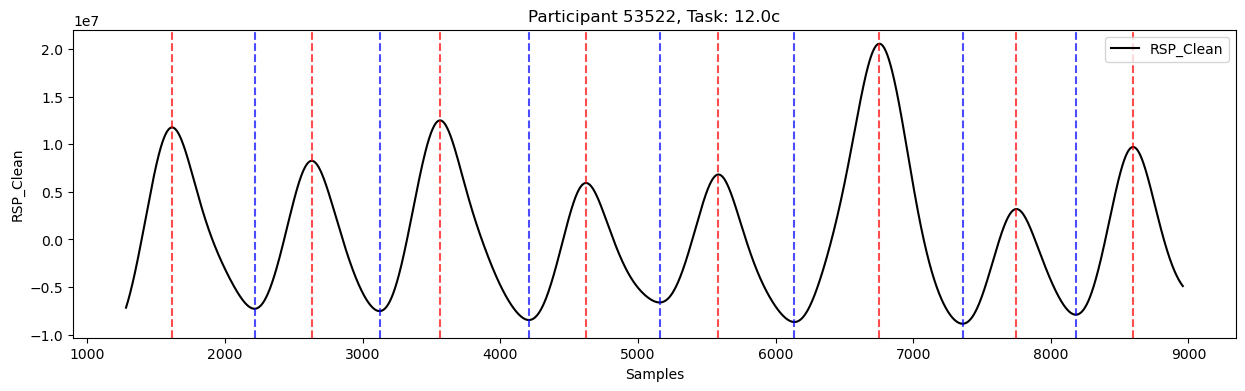

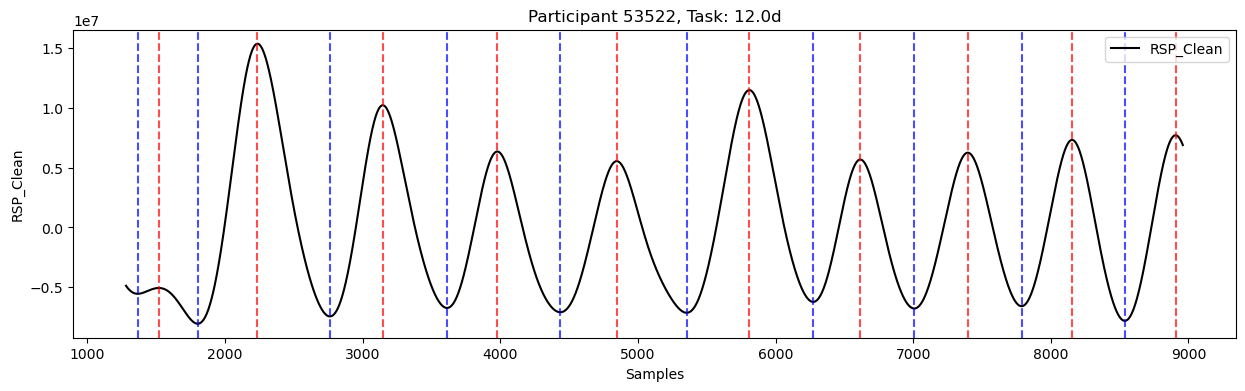

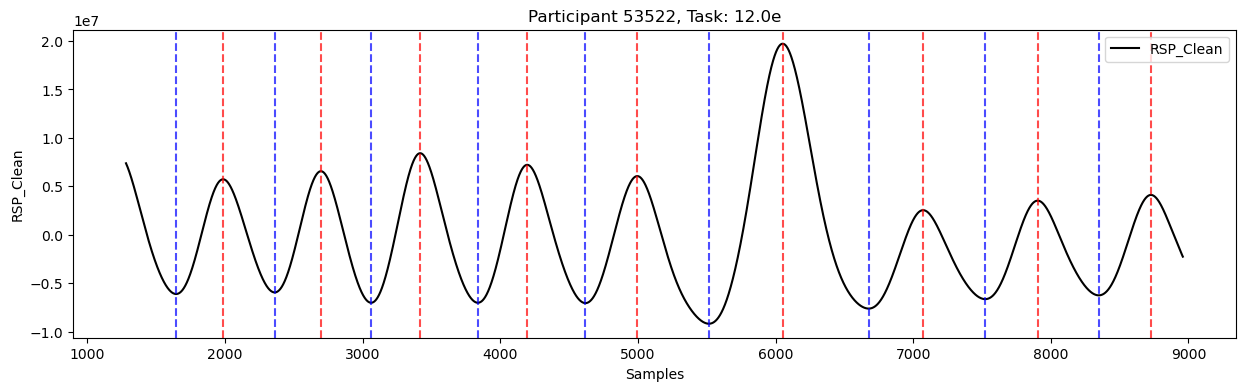

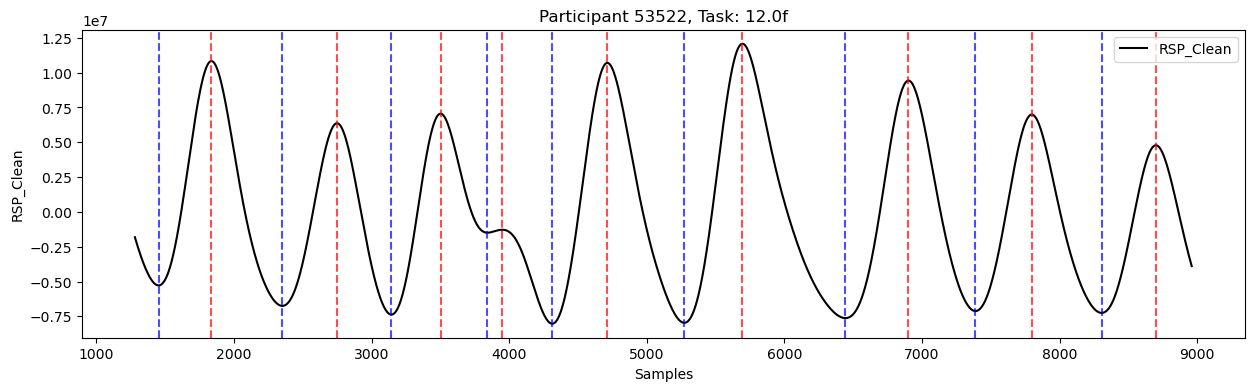

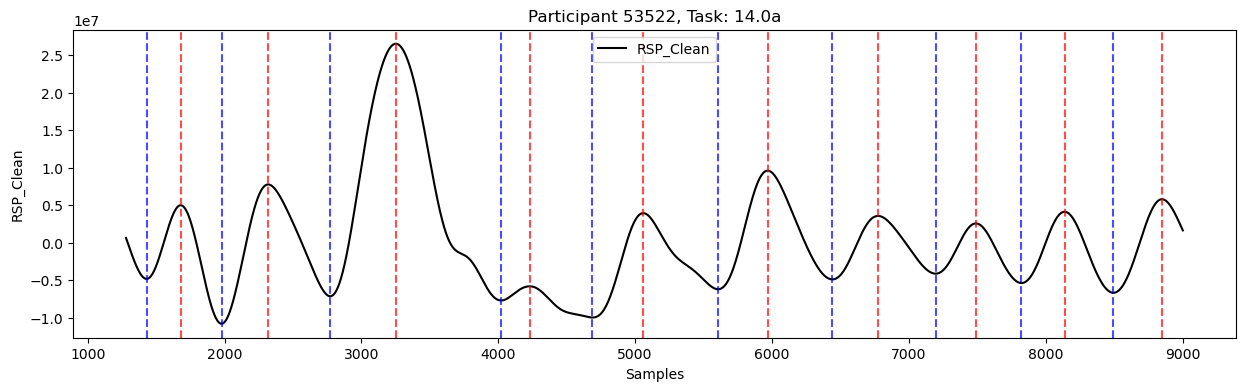

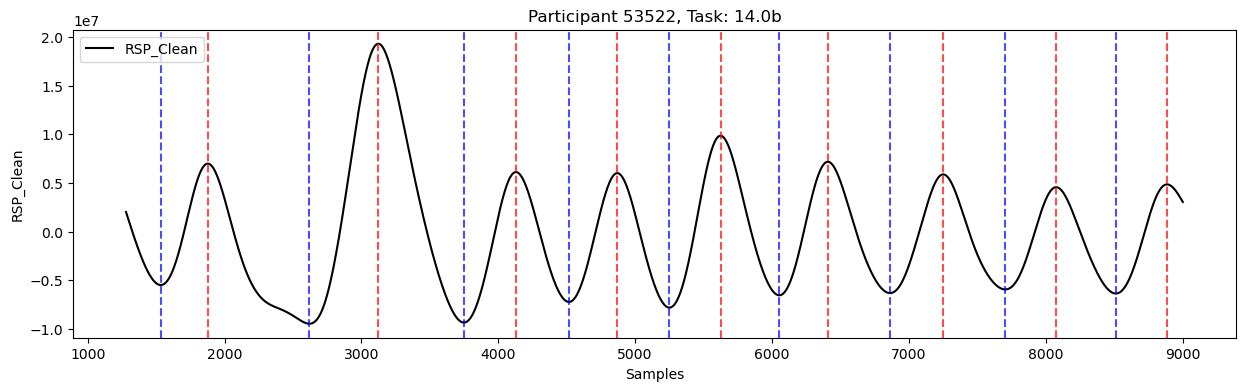

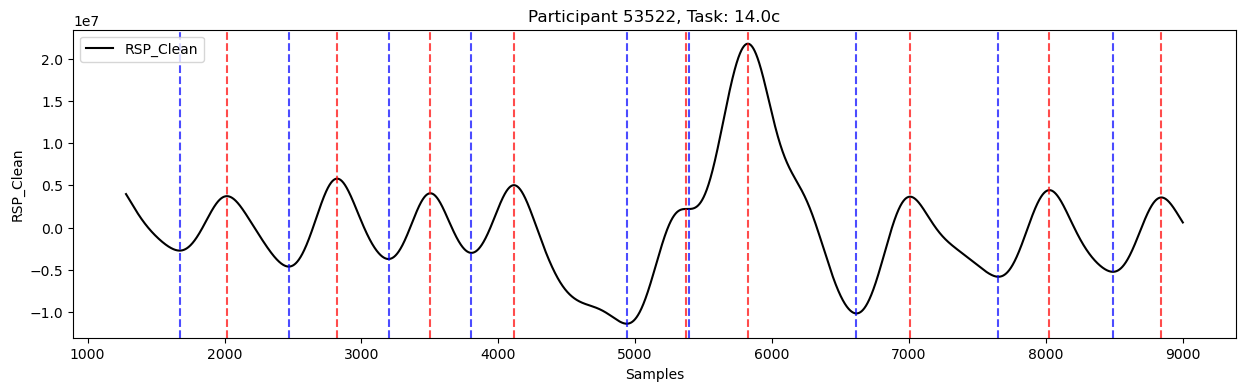

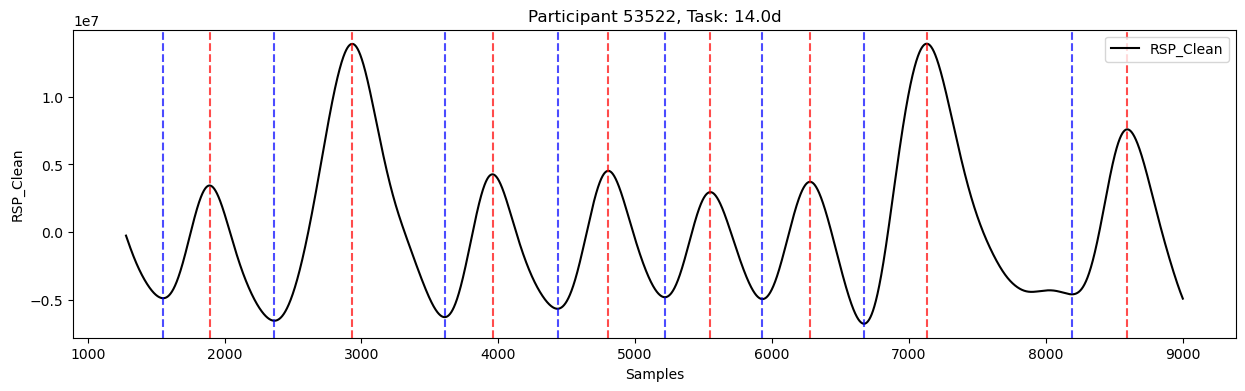

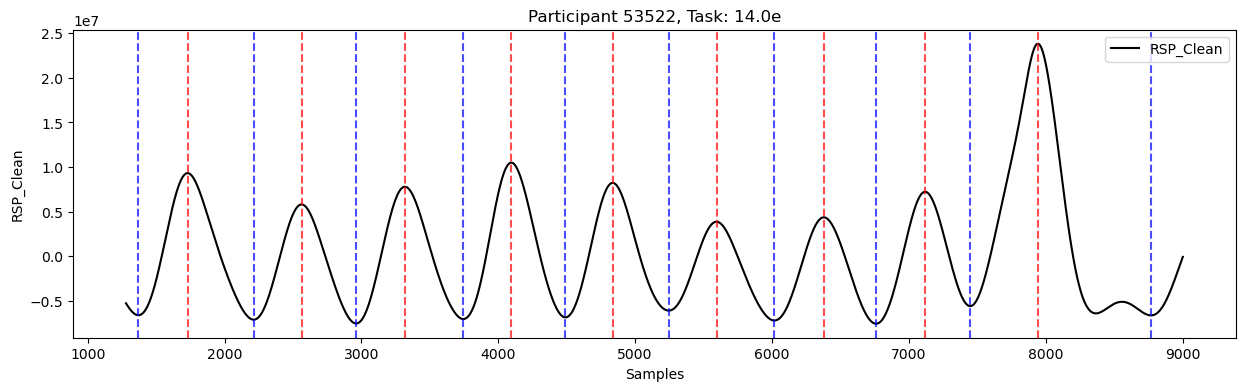

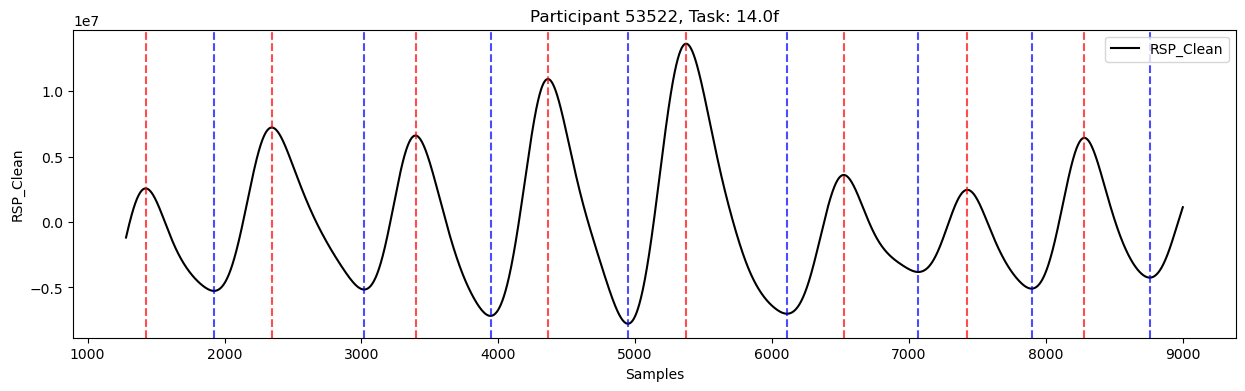

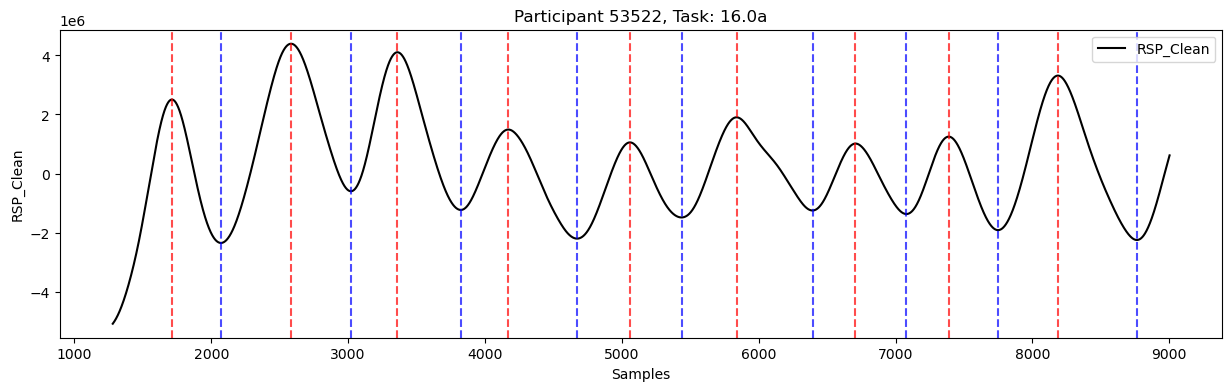

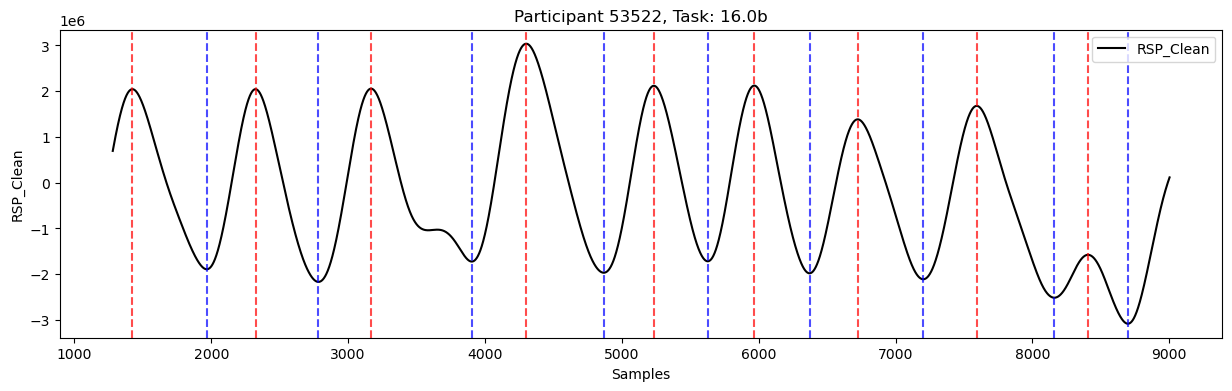

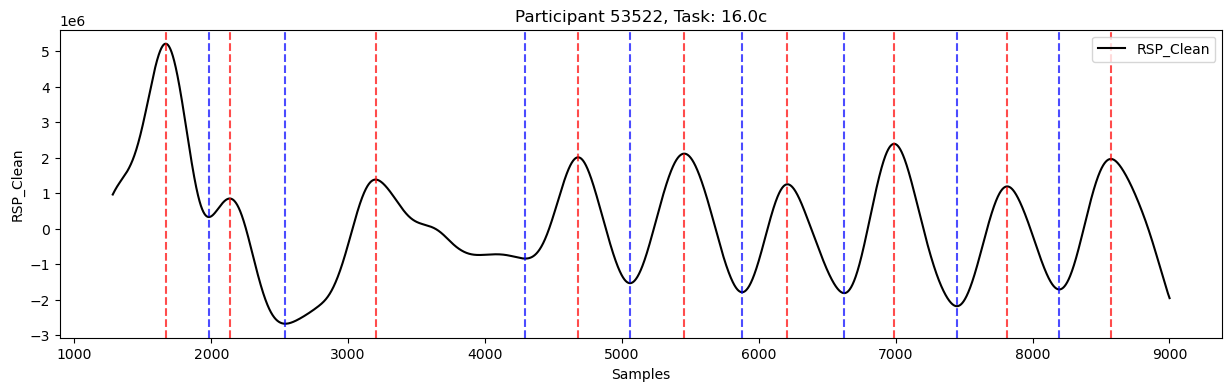

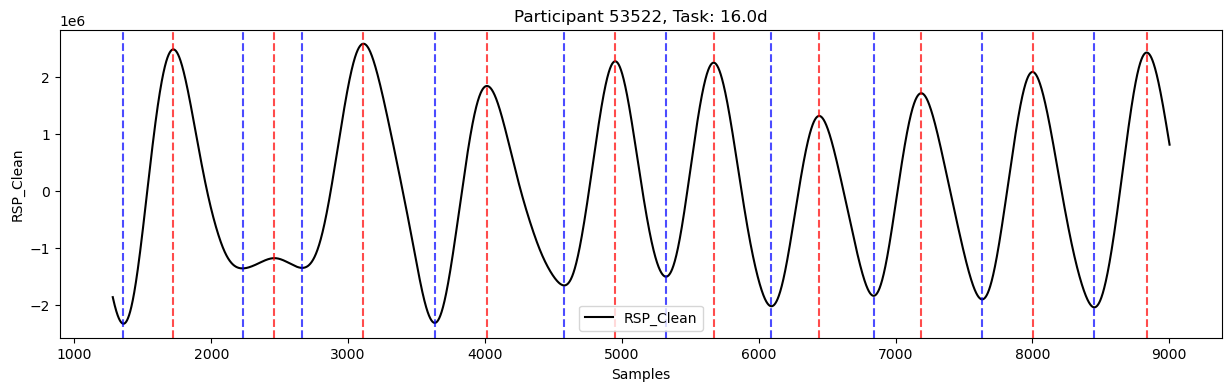

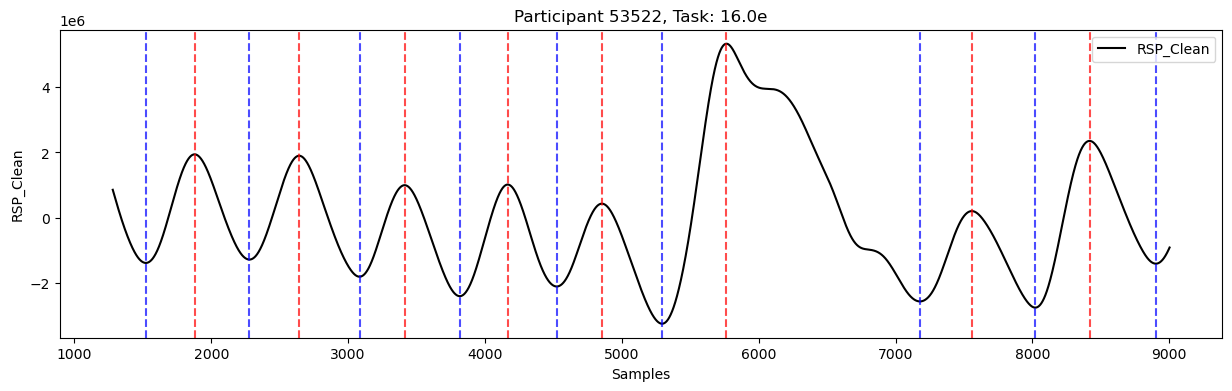

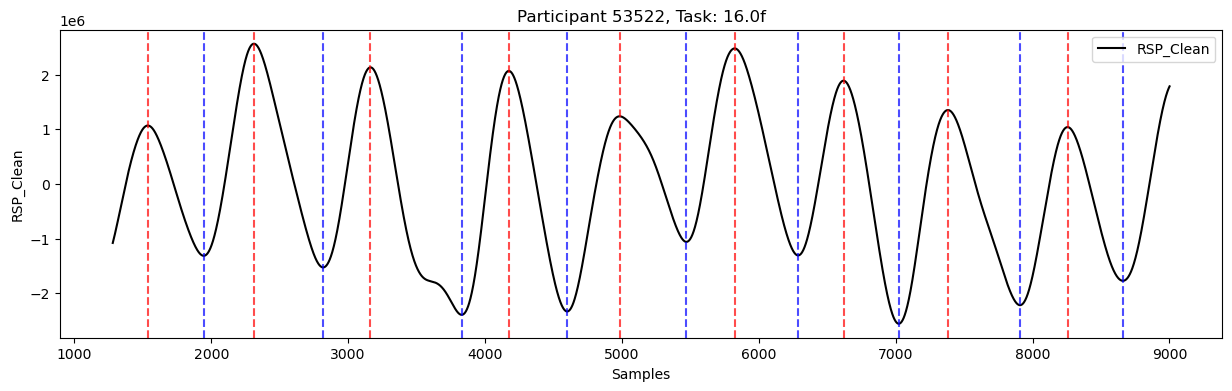

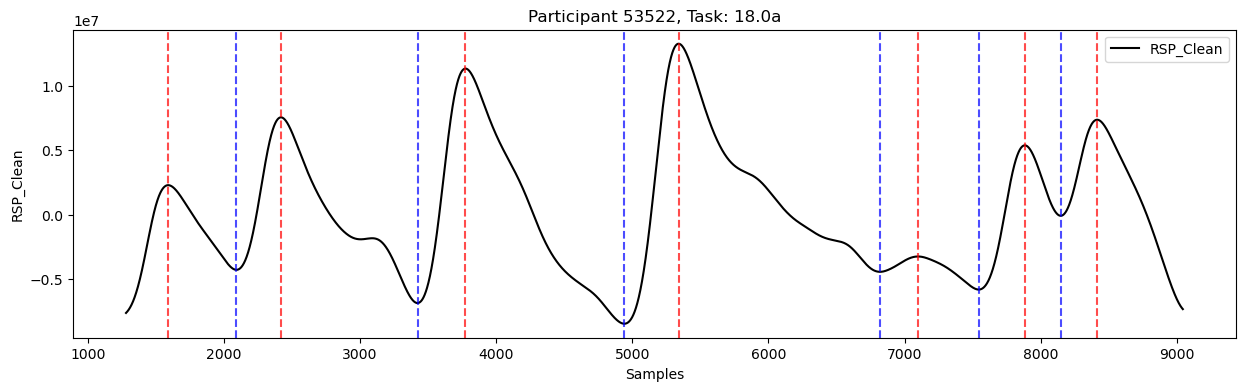

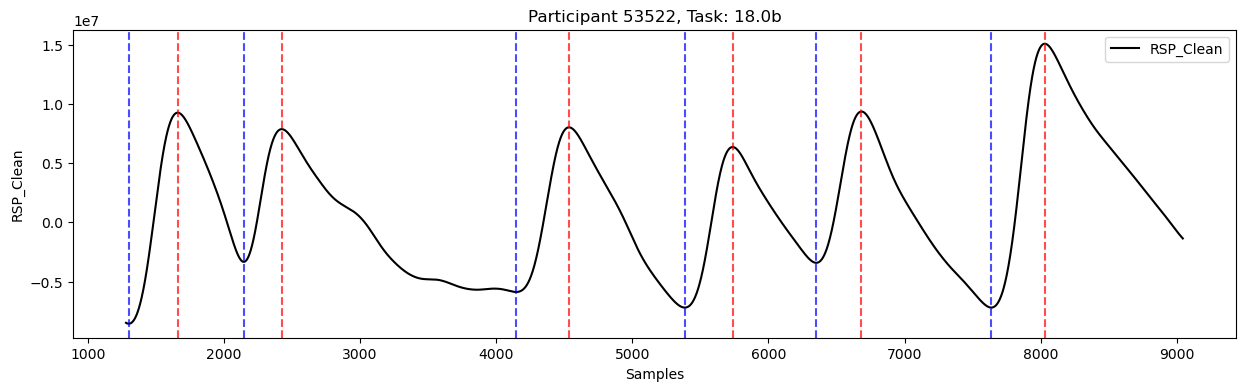

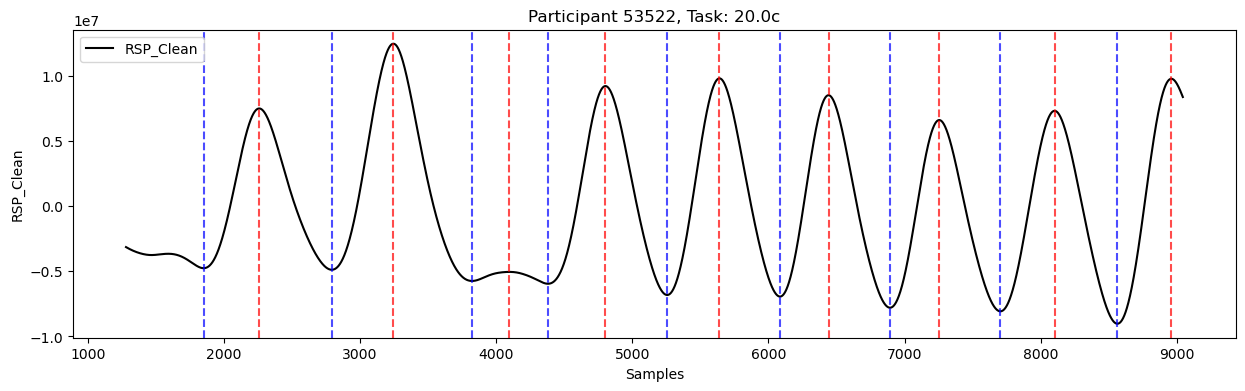

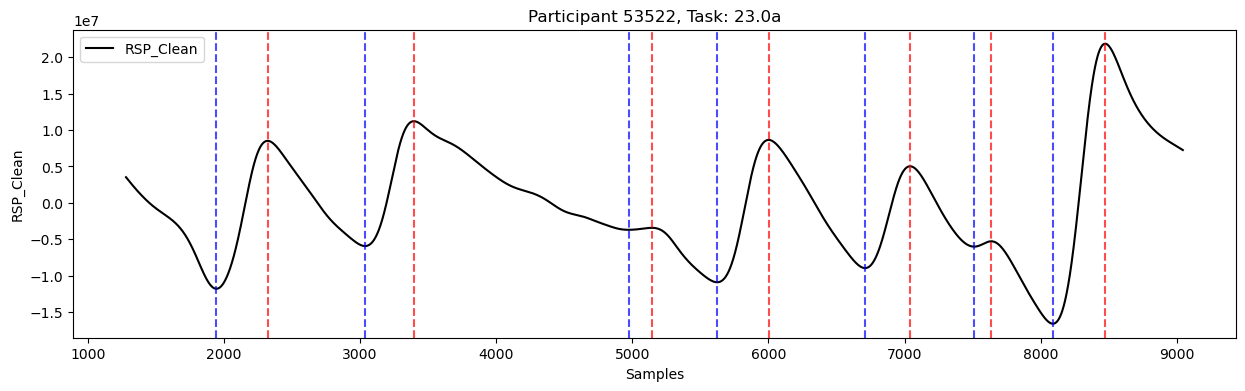

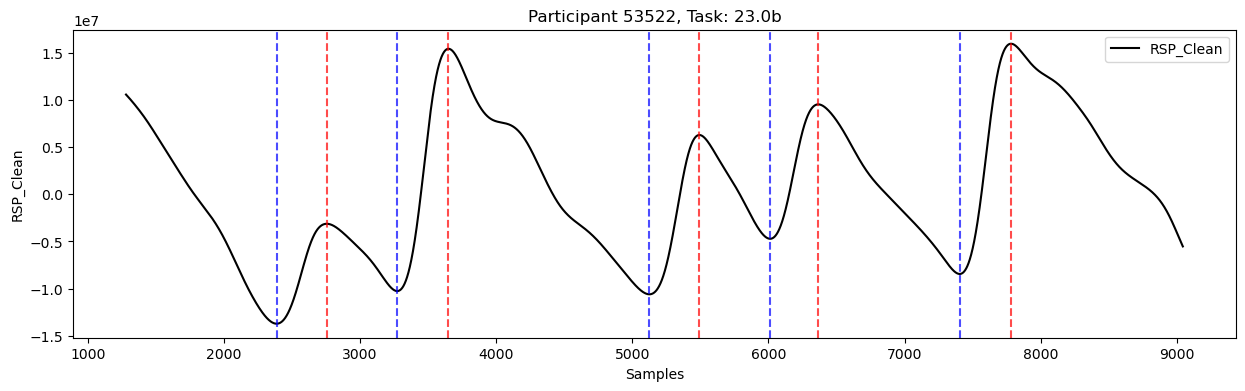

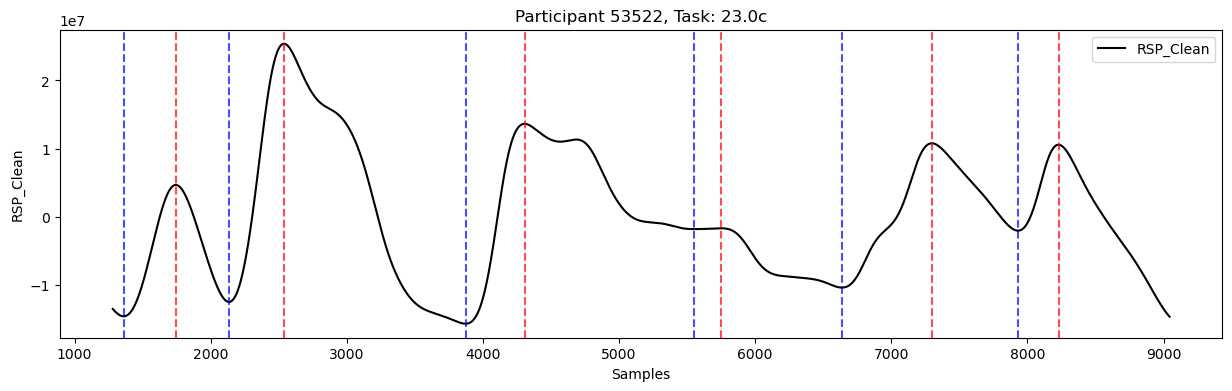

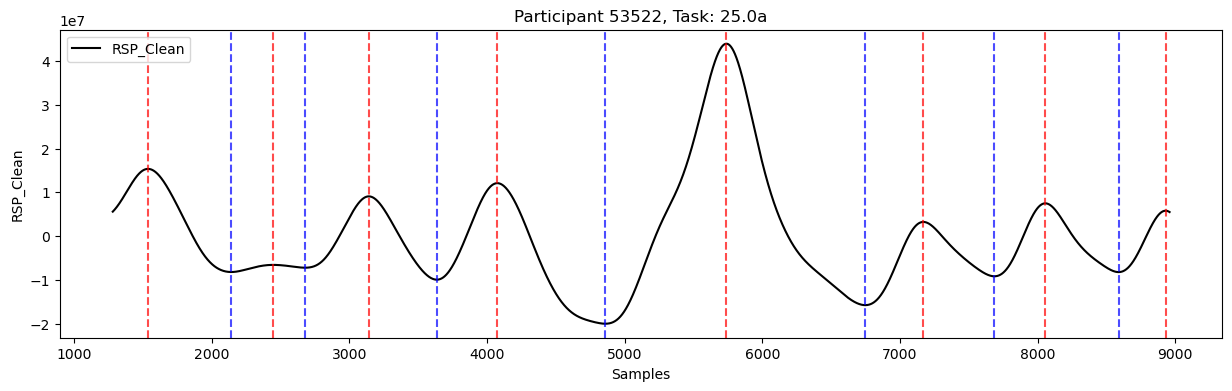

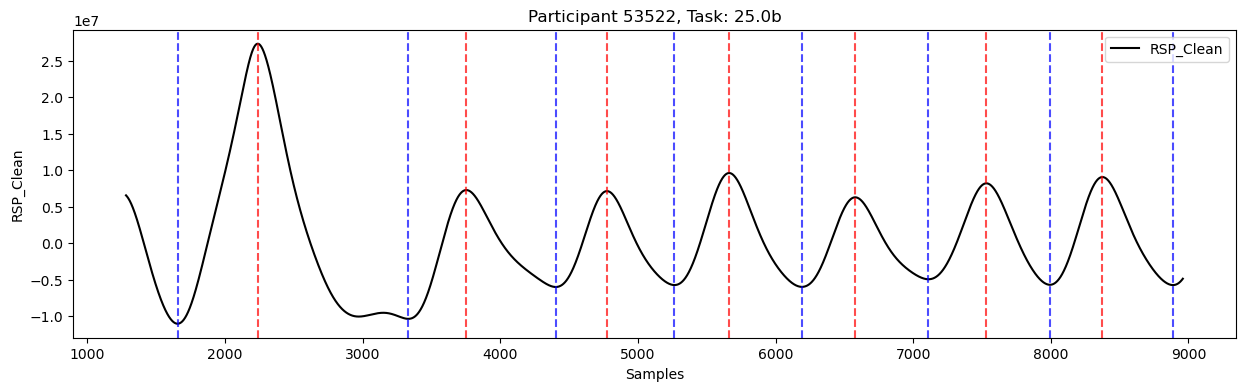

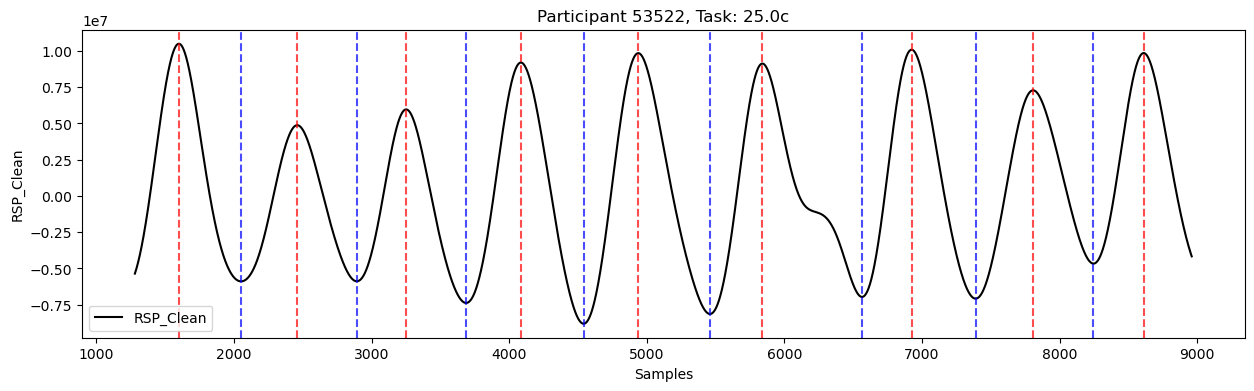

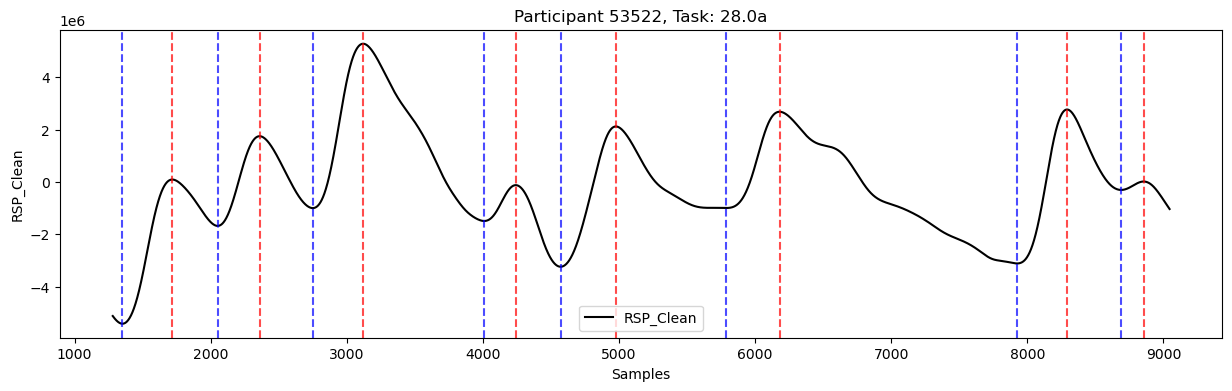

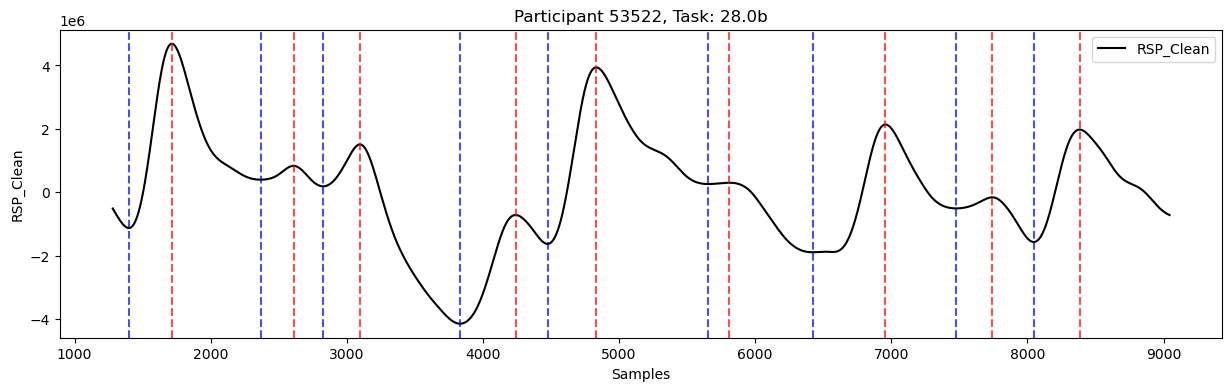

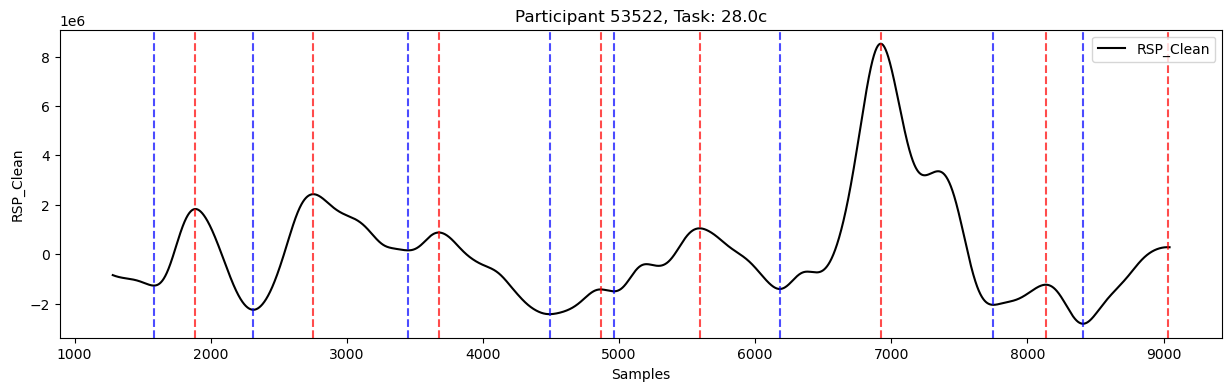

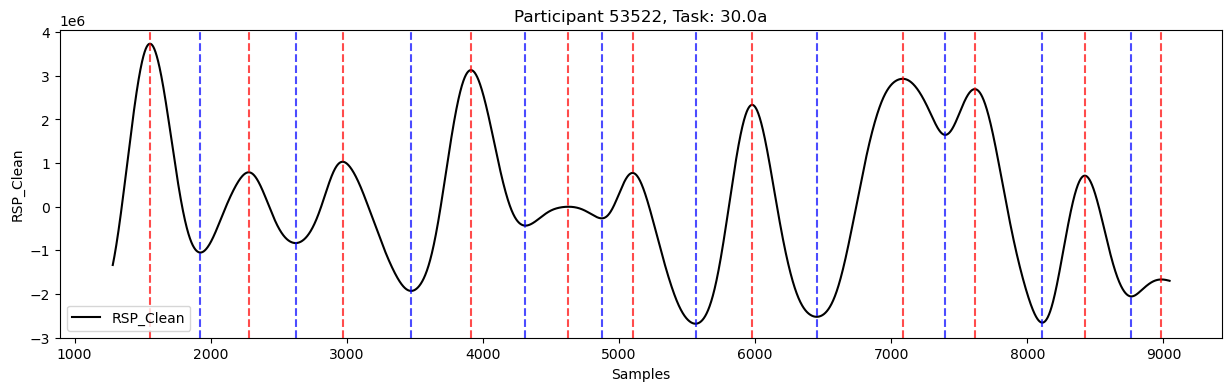

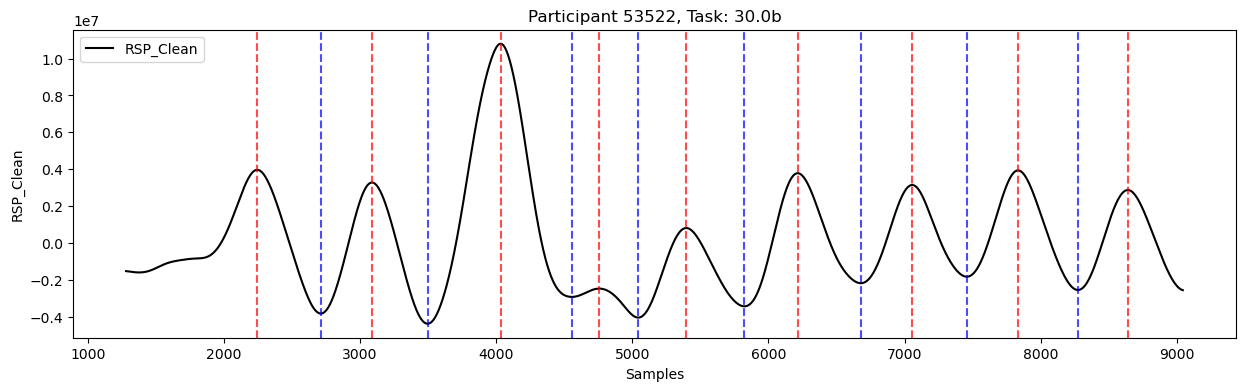

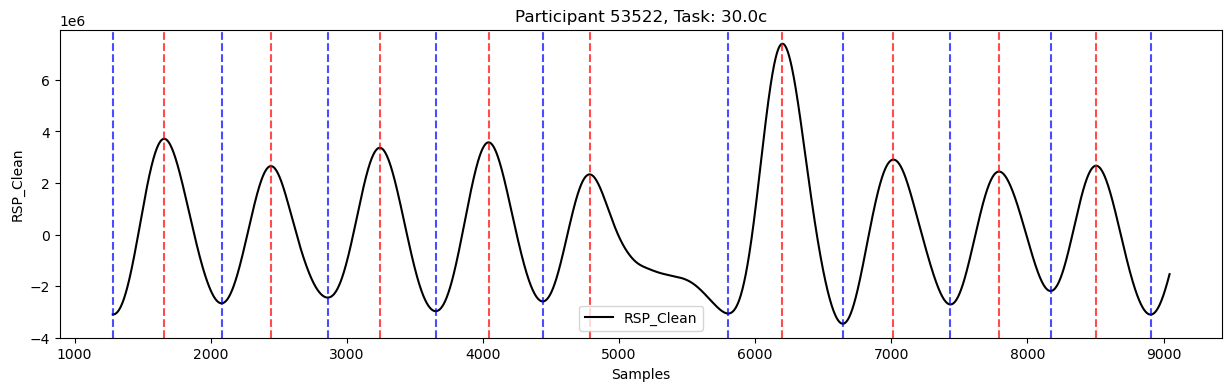

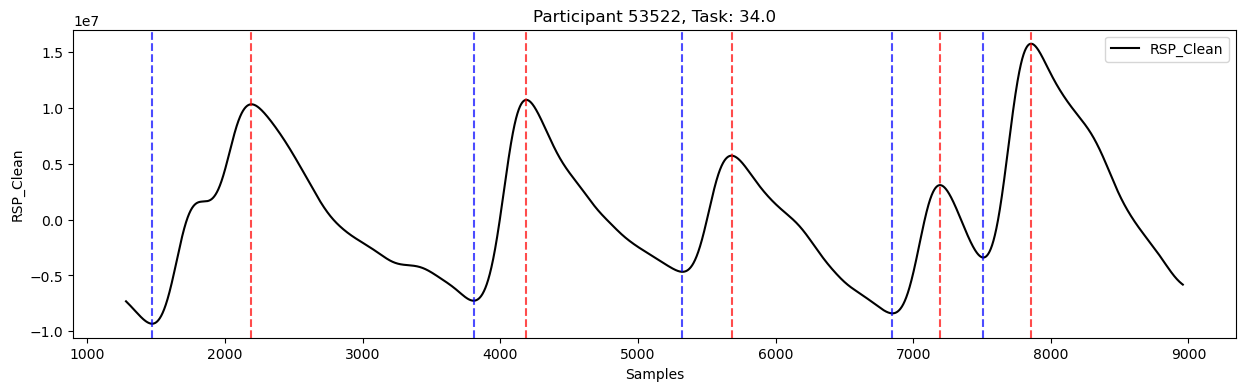

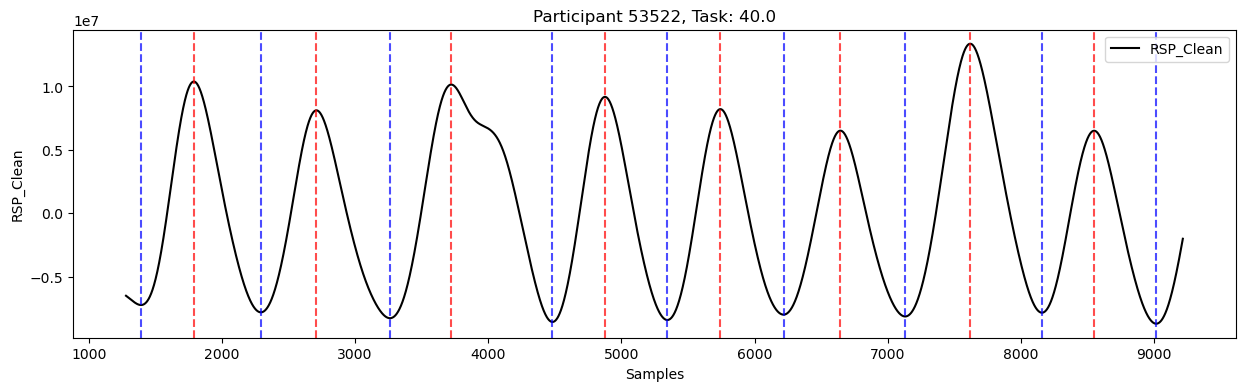

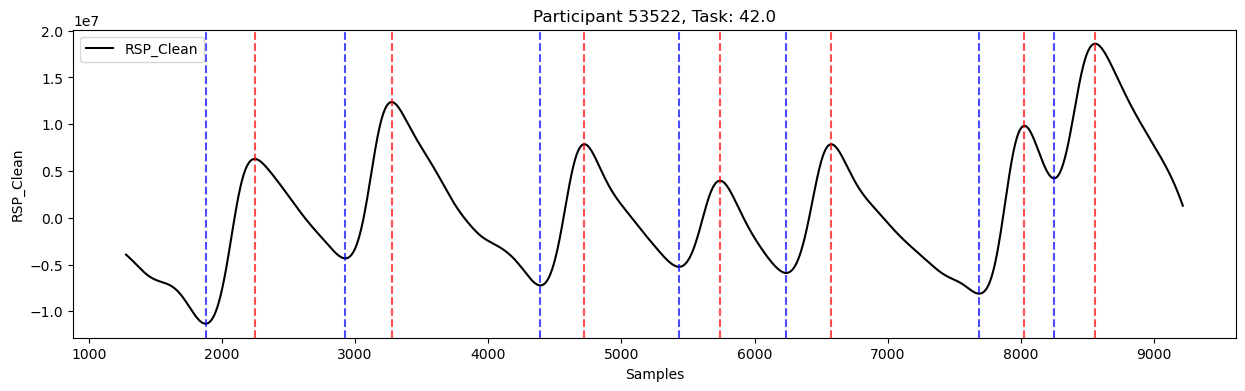

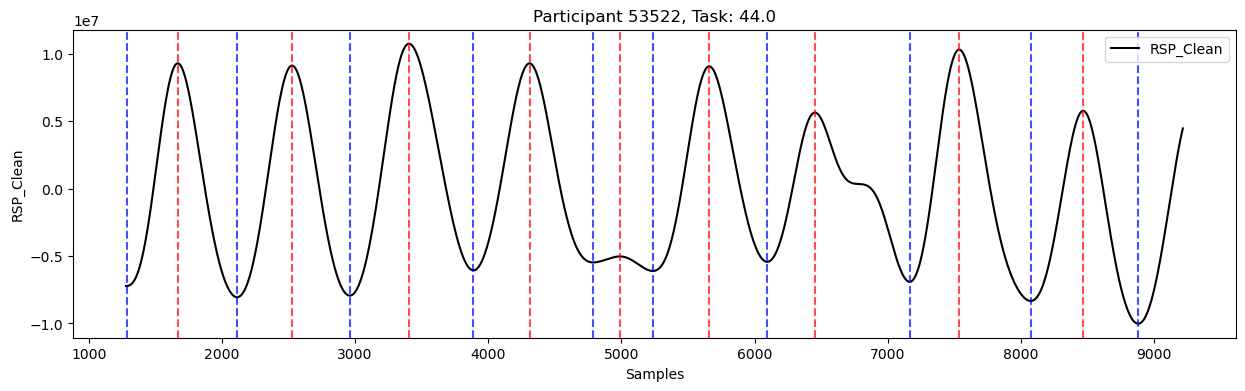

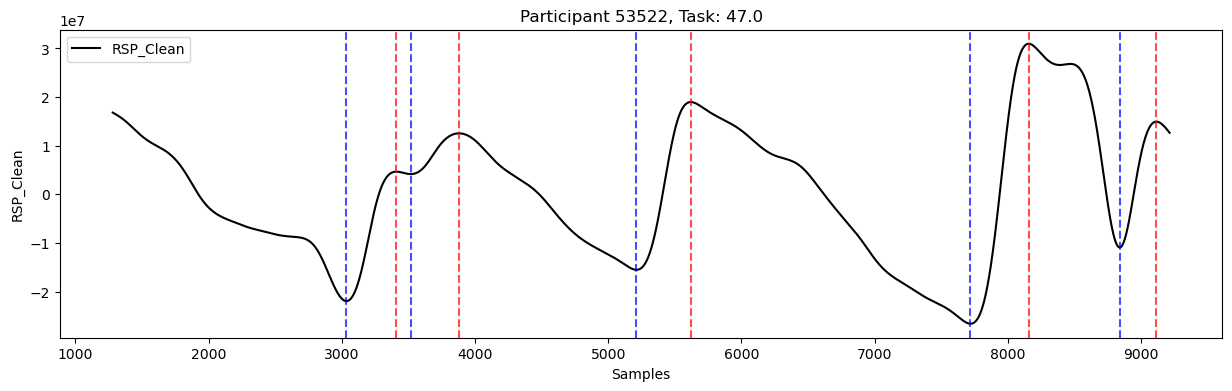

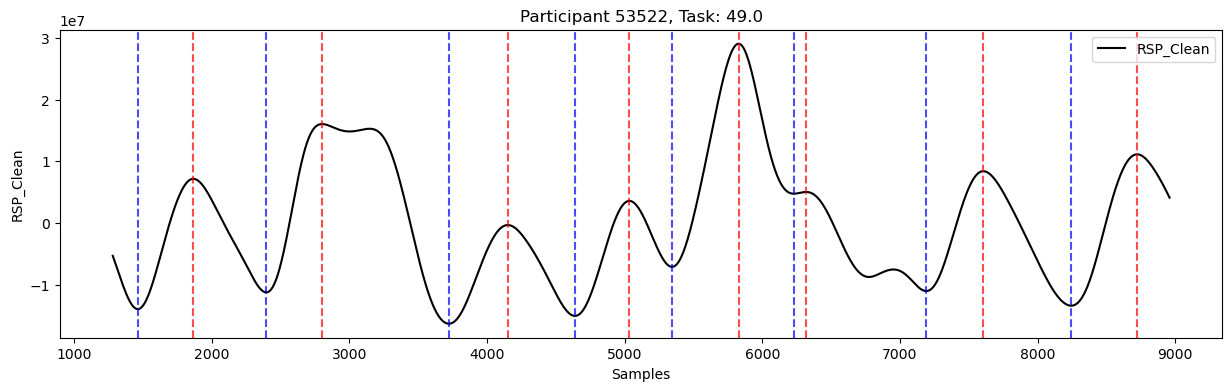

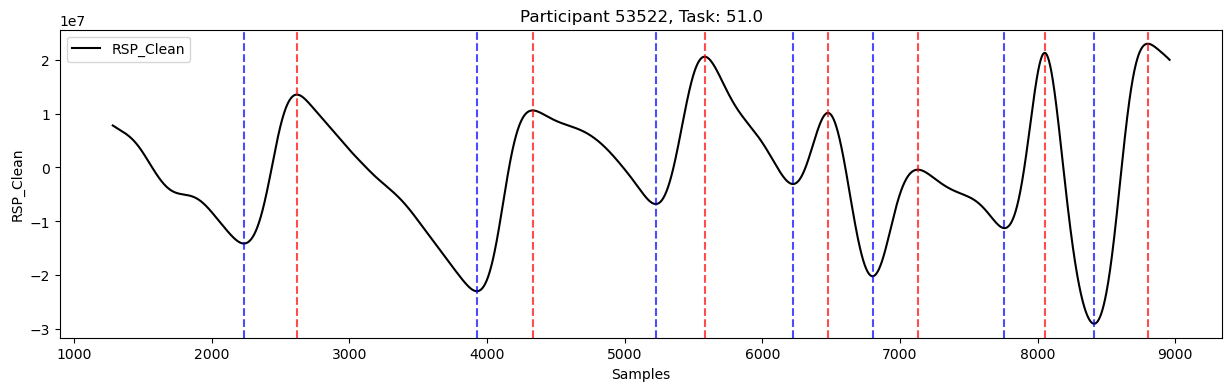

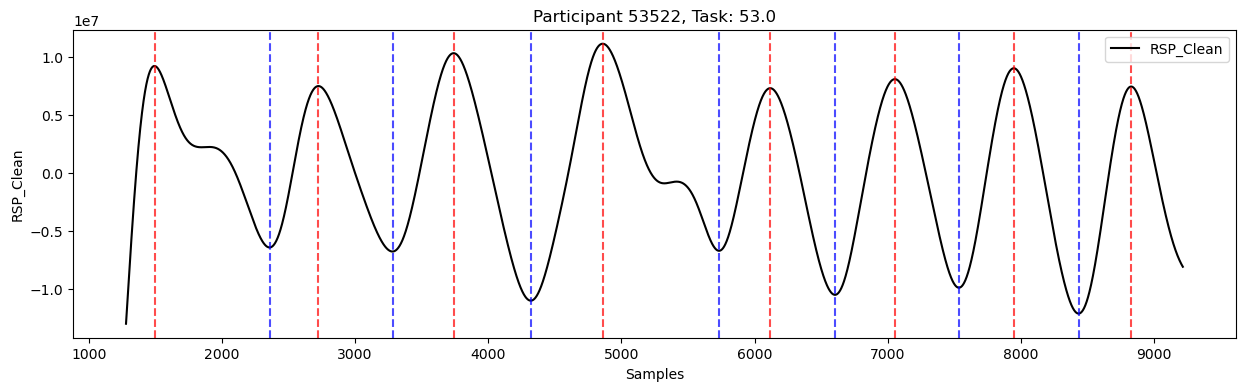

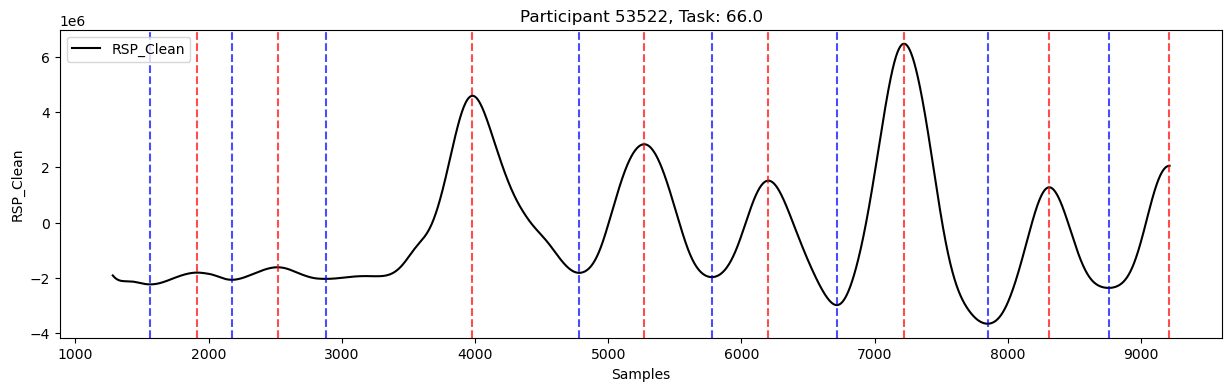

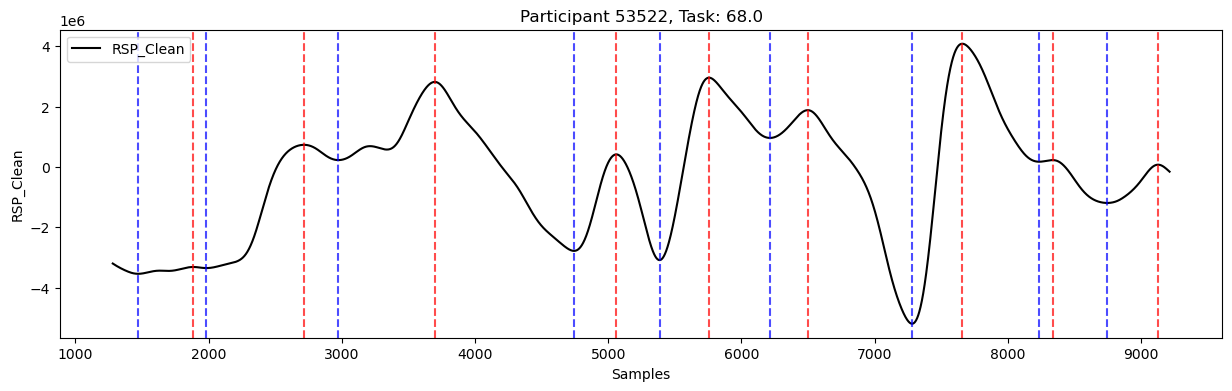

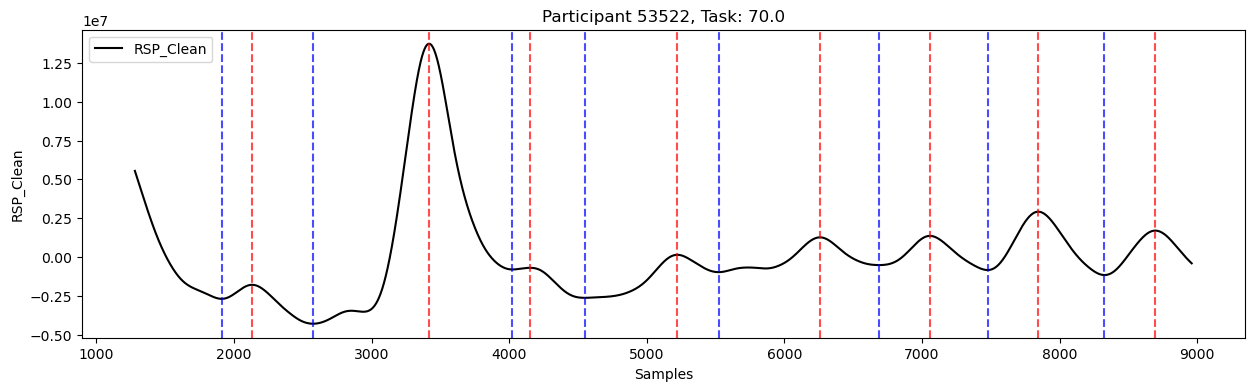

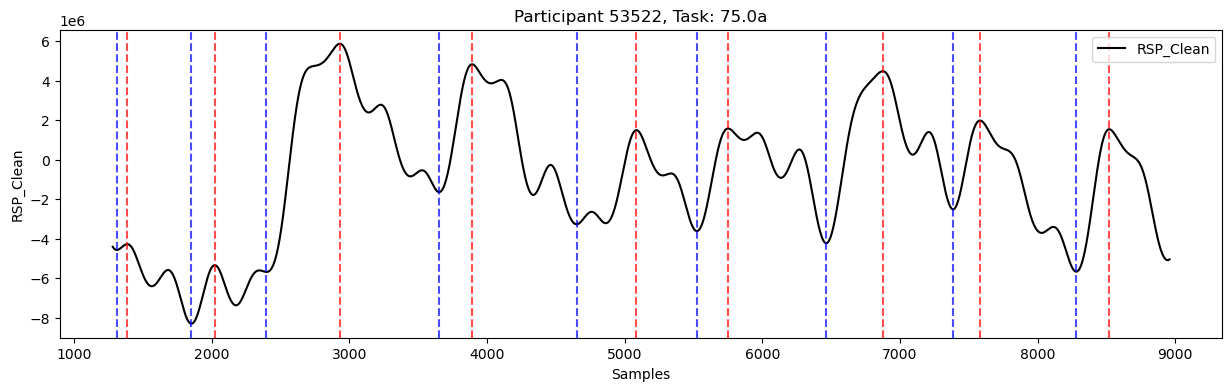

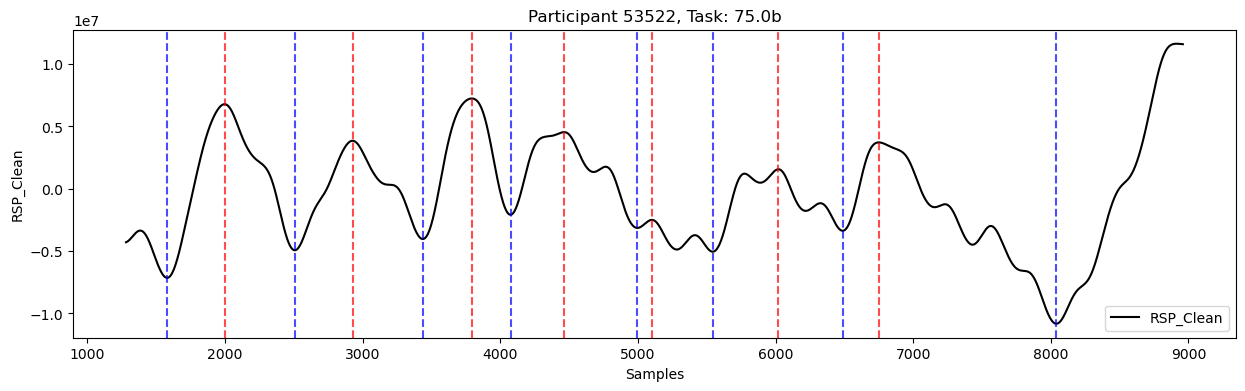

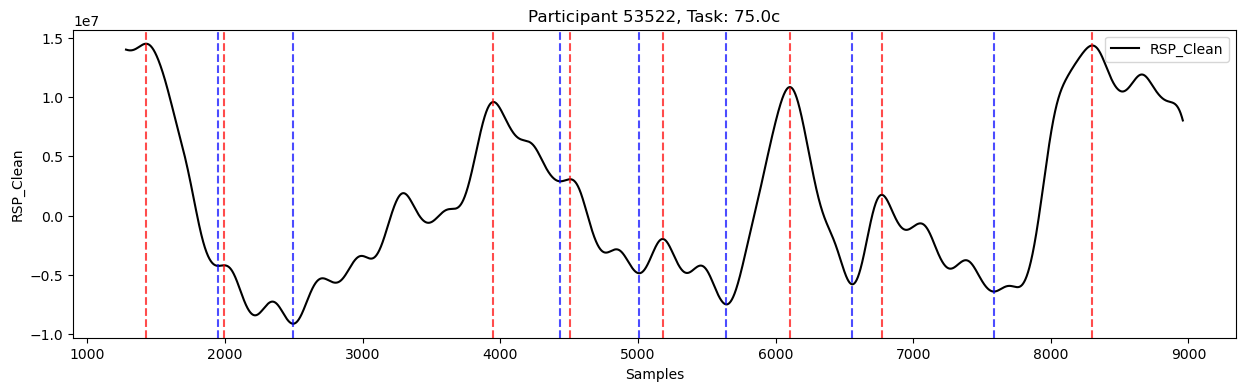

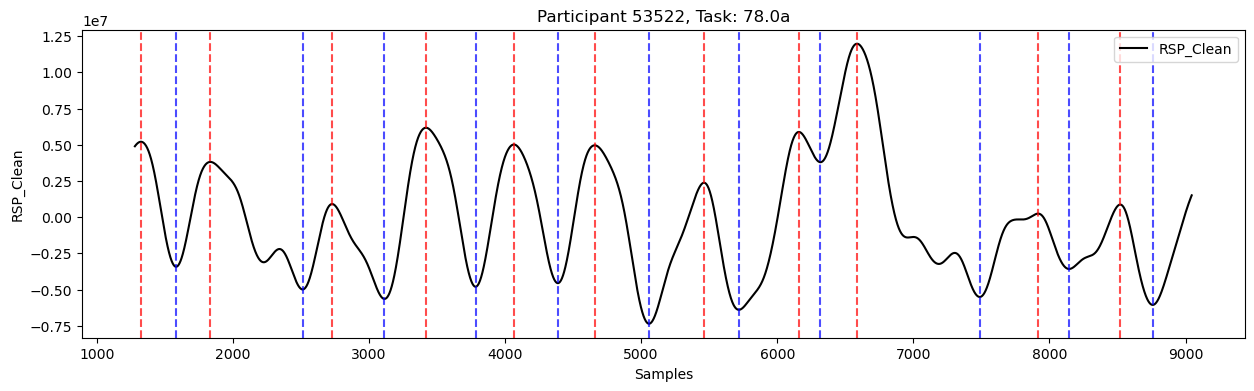

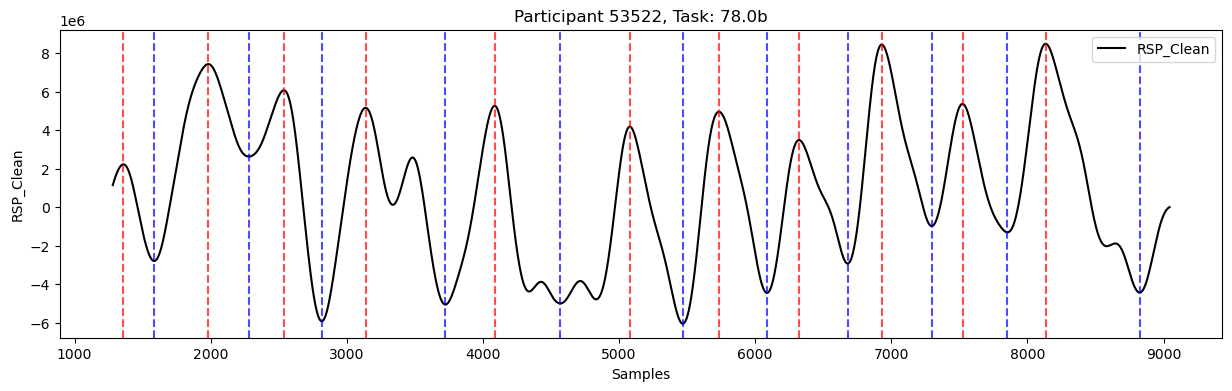

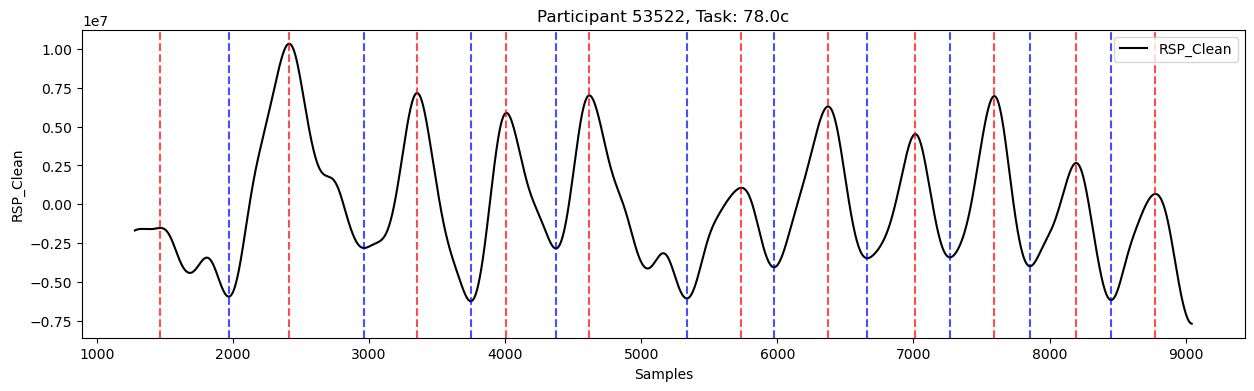

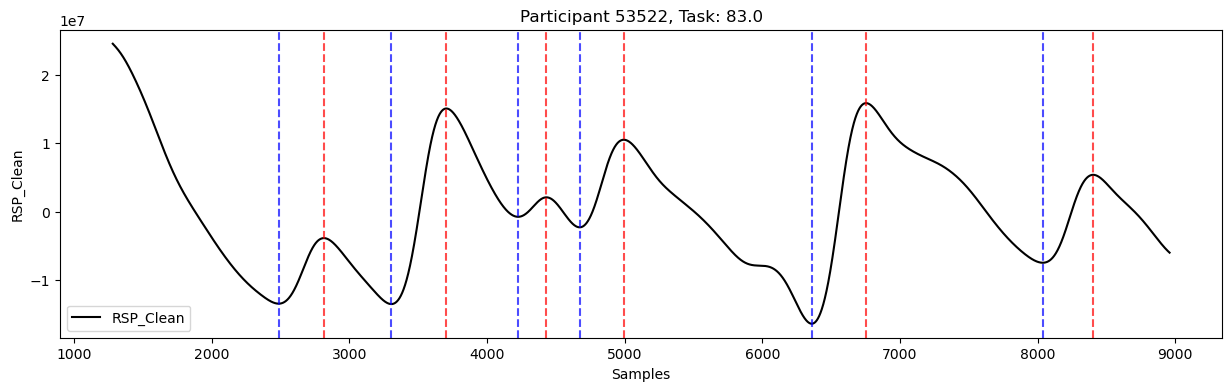

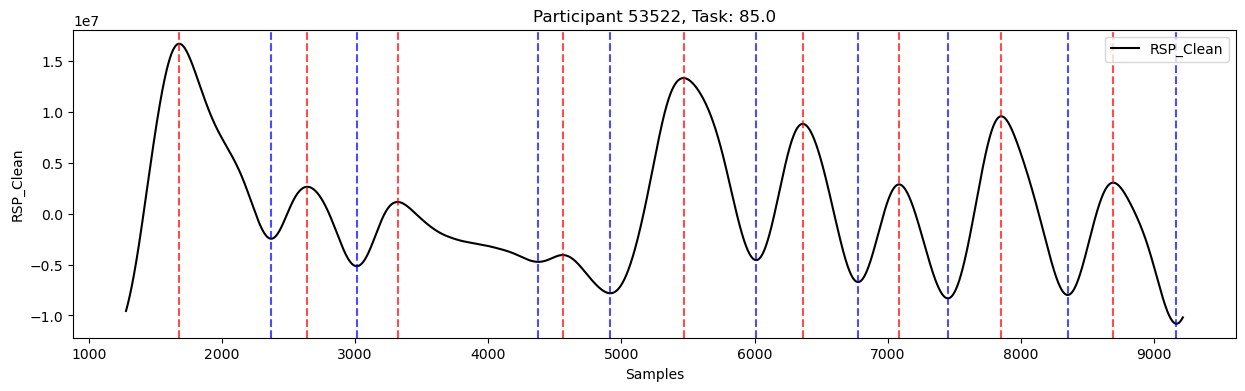

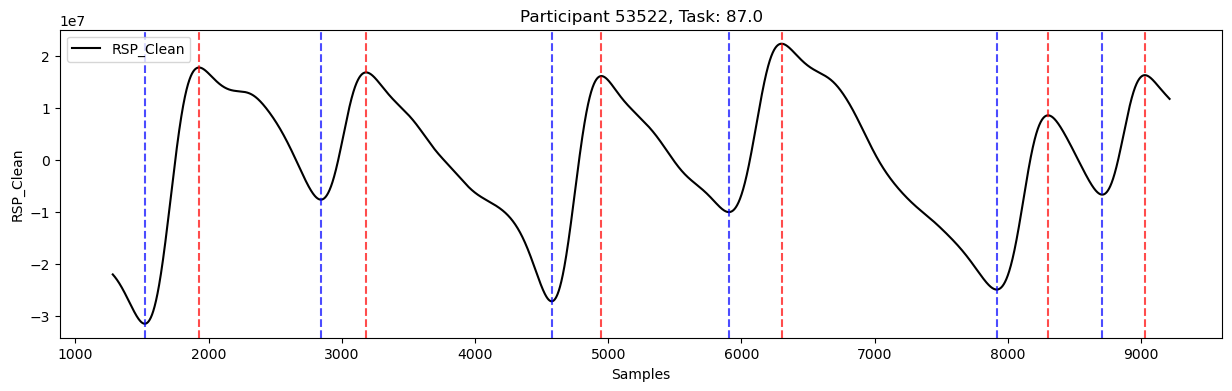

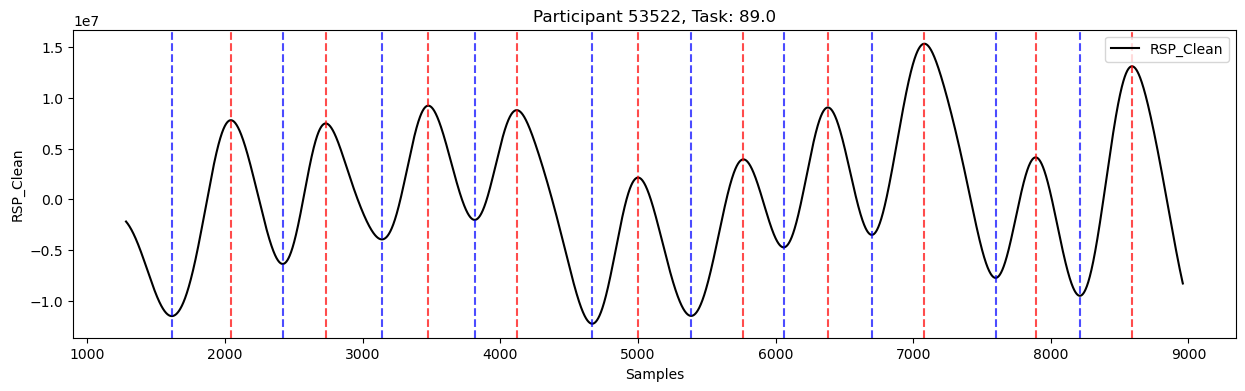

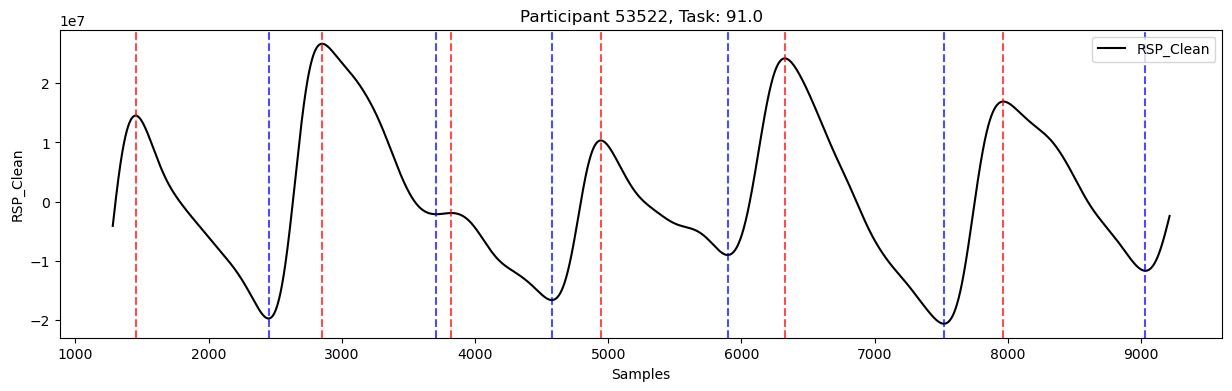

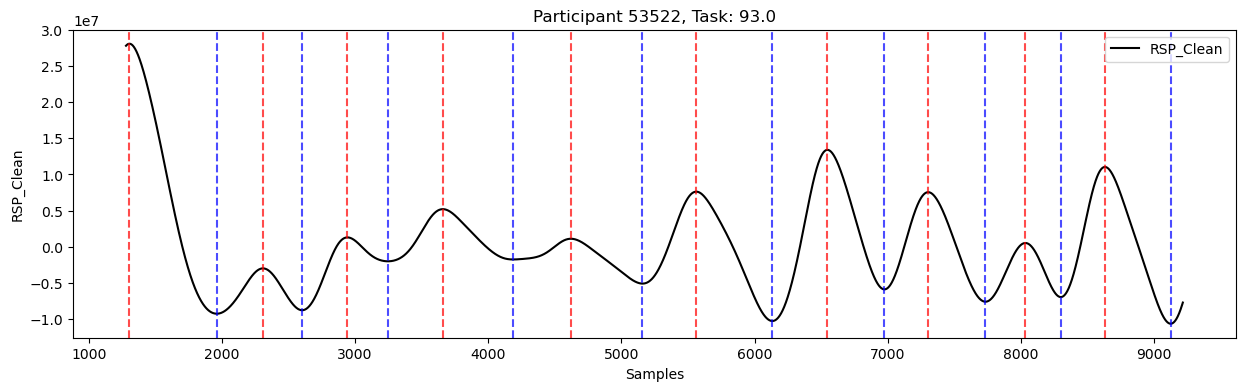

In [5]:
#let's run the function for the dataset we just uploaded
import neurokit2 as nk
import matplotlib.pyplot as plt

tasks = ['12.0a', '12.0b', '12.0c', '12.0d', '12.0e', '12.0f', '14.0a', '14.0b', '14.0c', '14.0d', '14.0e',
         '14.0f', '16.0a', '16.0b', '16.0c', '16.0d', '16.0e', '16.0f', '18.0a', '18.0b', '18.0c', '20.0a',
         '20.0b', '20.0c', '23.0a', '23.0b', '23.0c', '25.0a', '25.0b', '25.0c', '28.0a', '28.0b', '28.0c',
         '30.0a', '30.0b', '30.0c', 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 60.0,
         62.0, 64.0, 66.0, 68.0, 70.0, '75.0a', '75.0b', '75.0c', '78.0a', '78.0b', '78.0c', 83.0, 85.0, 87.0,
         89.0, 91.0, 93.0]

all_processed_data = {}

all_processed_data = process_and_visualize(df_abdomen, tasks)


In [6]:
all_processed_data #contains, for each segment of interest + 5 seconds before and after, the RSP_Clean, RSP_Peaks, RSP_Troughs
#prior to feature extraction, let's double-check the variable contains the dataframes

{'12.0a':             RSP_Raw     RSP_Clean  RSP_Amplitude   RSP_Rate       RSP_RVT  \
 0     -1.450300e+10 -1.553288e+06   1.967411e+07  12.431495  2.419334e+06   
 1     -1.450153e+10 -1.587074e+06   1.967411e+07  12.431495  2.419537e+06   
 2     -1.450300e+10 -1.621103e+06   1.967411e+07  12.431495  2.419773e+06   
 3     -1.450388e+10 -1.655372e+06   1.967411e+07  12.431495  2.420041e+06   
 4     -1.450300e+10 -1.689880e+06   1.967411e+07  12.431495  2.420342e+06   
 ...             ...           ...            ...        ...           ...   
 10235 -1.450877e+10 -6.765662e+03   2.117341e+07  13.128205  4.999358e+05   
 10236 -1.450800e+10 -5.746251e+03   2.117341e+07  13.128205  4.997415e+05   
 10237 -1.450638e+10 -4.835017e+03   2.117341e+07  13.128205  4.995604e+05   
 10238 -1.450700e+10 -4.026106e+03   2.117341e+07  13.128205  4.993923e+05   
 10239 -1.451089e+10 -3.313482e+03   2.117341e+07  13.128205  4.992373e+05   
 
        RSP_Phase  RSP_Phase_Completion  RSP_Symmetry

In [7]:
import numpy as np 
import pandas as pd
#this code extracts features that don't come from neurokit (all features except respiratory rate, RRV, and peak-trough symmtery)
processed_dataframes = all_processed_data
sampling_rate = 256  #if the sampling rate is different for your data, change
task_results = {}
bbb_results = {}

for task, df in processed_dataframes.items():
    print(f"Task: {task}")

    # filter each dataframe for the actual task duration
    task_specific_df = df[df['Task_Label_2'] == task]
    peaks = task_specific_df[task_specific_df['RSP_Peaks'] == 1].index
    troughs = task_specific_df[task_specific_df['RSP_Troughs'] == 1].index

    # combine peaks and troughs into one list and sort
    combined_data = [('Peak', index) for index in peaks] + [('Trough', index) for index in troughs]
    combined_data.sort(key=lambda x: x[1])

    # initialize lists to store durations, amplitudes, flow rates, I:E ratios, and duty cycles
    inspiratory_durations = []
    expiratory_durations = []
    inspiratory_amplitudes = []
    expiratory_amplitudes = []
    inspiratory_flows = []
    expiratory_flows = []
    ie_ratios = []
    duty_cycles = []
    exp_diffs = []

    # iterate through combined data
    for i in range(1, len(combined_data)):
        current_type, current_index = combined_data[i]
        prev_type, prev_index = combined_data[i-1]

        # calculate duration and amplitude
        duration = (current_index - prev_index) / sampling_rate
        amplitude = abs(df.loc[current_index, 'RSP_Clean'] - df.loc[prev_index, 'RSP_Clean'])

        # calculate inspiratory duration, amplitude, and flow rate
        if current_type == 'Peak' and prev_type == 'Trough':
            inspiratory_durations.append(duration)
            inspiratory_amplitudes.append(amplitude)
            if duration > 0:
                inspiratory_flows.append(amplitude / duration)

        # calculate expiratory duration, amplitude, and flow rate
        elif current_type == 'Trough' and prev_type == 'Peak':
            expiratory_durations.append(duration)
            expiratory_amplitudes.append(amplitude)
            if duration > 0:
                expiratory_flows.append(amplitude / duration)
            if inspiratory_durations:
                ie_ratios.append(inspiratory_durations[-1] / duration)
                # Ensure duty cycle is calculated within each breath cycle
                total_cycle_duration = inspiratory_durations[-1] + expiratory_durations[-1]
                duty_cycle = inspiratory_durations[-1] / total_cycle_duration
                duty_cycles.append(duty_cycle)

    # calculate first-order exhalatory differences
    if len(expiratory_durations) > 1:
        exp_diffs = [abs(expiratory_durations[i] - expiratory_durations[i - 1]) for i in range(1, len(expiratory_durations))]

    # calculate mean and SD for durations, amplitudes, flow rates, I:E ratios, and duty cycles
    insp_dur_mean, insp_dur_sd = np.mean(inspiratory_durations), np.std(inspiratory_durations)
    exp_dur_mean, exp_dur_sd = np.mean(expiratory_durations), np.std(expiratory_durations)
    insp_amp_mean, insp_amp_sd = np.mean(inspiratory_amplitudes), np.std(inspiratory_amplitudes)
    exp_amp_mean, exp_amp_sd = np.mean(expiratory_amplitudes), np.std(expiratory_amplitudes)
    insp_flow_mean, insp_flow_sd = np.mean(inspiratory_flows), np.std(inspiratory_flows)
    exp_flow_mean, exp_flow_sd = np.mean(expiratory_flows), np.std(expiratory_flows)
    ie_ratio_mean, ie_ratio_sd = np.mean(ie_ratios), np.std(ie_ratios)
    duty_cycle_mean = np.mean(duty_cycles)
    exp_diff_mean = np.mean(exp_diffs) if exp_diffs else 0

    task_results[task] = {
        'insp_dur_mean': insp_dur_mean,
        'insp_dur_sd': insp_dur_sd,
        'exp_dur_mean': exp_dur_mean,
        'exp_dur_sd': exp_dur_sd,
        'insp_amp_mean': insp_amp_mean,
        'insp_amp_sd': insp_amp_sd,
        'exp_amp_mean': exp_amp_mean,
        'exp_amp_sd': exp_amp_sd,
        'insp_flow_mean': insp_flow_mean,
        'insp_flow_sd': insp_flow_sd,
        'exp_flow_mean': exp_flow_mean,
        'exp_flow_sd': exp_flow_sd,
        'ie_ratio_mean': ie_ratio_mean,
        'ie_ratio_sd': ie_ratio_sd,
        'duty_cycle_mean': duty_cycle_mean,
        'exp_diff_mean': exp_diff_mean
    }

    # store the breath-by-breath results separately
    bbb_results[task] = {
        'inspiratory_durations': inspiratory_durations,
        'expiratory_durations': expiratory_durations,
        'inspiratory_amplitudes': inspiratory_amplitudes,
        'expiratory_amplitudes': expiratory_amplitudes,
        'inspiratory_flows': inspiratory_flows,
        'expiratory_flows': expiratory_flows,
        'ie_ratios': ie_ratios,
        'duty_cycles': duty_cycles,
        'exp_diffs': exp_diffs
    }

# convert the dictionary to a data frame for task_results
respiratory_analysis_df = pd.DataFrame.from_dict(task_results, orient='index')
respiratory_analysis_df.reset_index(inplace=True)
respiratory_analysis_df.rename(columns={'index': 'Task_Label'}, inplace=True)

# create a dataframe for bbb_results
bbb_dataframe = pd.DataFrame.from_dict(bbb_results, orient='index')
bbb_dataframe.reset_index(inplace=True)
bbb_dataframe.rename(columns={'index': 'Task_Label'}, inplace=True)

#display the dataframe containing the features
respiratory_analysis_df


Task: 12.0a
Task: 12.0b
Task: 12.0c
Task: 12.0d
Task: 12.0e
Task: 12.0f
Task: 14.0a
Task: 14.0b
Task: 14.0c
Task: 14.0d
Task: 14.0e
Task: 14.0f
Task: 16.0a
Task: 16.0b
Task: 16.0c
Task: 16.0d
Task: 16.0e
Task: 16.0f
Task: 18.0a
Task: 18.0b
Task: 18.0c
Task: 20.0a
Task: 20.0b
Task: 20.0c
Task: 23.0a
Task: 23.0b
Task: 23.0c
Task: 25.0a
Task: 25.0b
Task: 25.0c
Task: 28.0a
Task: 28.0b
Task: 28.0c
Task: 30.0a
Task: 30.0b
Task: 30.0c
Task: 34.0
Task: 36.0
Task: 38.0
Task: 40.0
Task: 42.0
Task: 44.0
Task: 47.0
Task: 49.0
Task: 51.0
Task: 53.0
Task: 55.0
Task: 57.0
Task: 60.0
Task: 62.0
Task: 64.0
Task: 66.0
Task: 68.0
Task: 70.0
Task: 75.0a
Task: 75.0b
Task: 75.0c
Task: 78.0a
Task: 78.0b
Task: 78.0c
Task: 83.0
Task: 85.0
Task: 87.0
Task: 89.0
Task: 91.0
Task: 93.0


Task_Label  insp_dur_mean  insp_dur_sd  exp_dur_mean  exp_dur_sd  \
0       12.0a       2.087500     0.093932      2.749349    0.339884   
1       12.0b       1.670759     0.463685      2.034180    0.517960   
2       12.0c       1.743304     0.279077      2.153460    0.263918   
3       12.0d       1.433594     0.305877      1.680122    0.277191   
4       12.0e       1.501736     0.221516      1.769043    0.308739   
..        ...            ...          ...           ...         ...   
61       85.0       1.323242     0.389396      2.073785    0.826212   
62       87.0       1.447266     0.121988      4.129688    1.637110   
63       89.0       1.355859     0.161356      1.521701    0.328905   
64       91.0       1.373438     0.477270      3.792318    0.554249   
65       93.0       1.436632     0.176947      1.760938    0.483996   

    insp_amp_mean   insp_amp_sd  exp_amp_mean    exp_amp_sd  insp_flow_mean  \
0    2.042551e+07  3.019048e+06  2.508239e+07  1.277432e+07    9.775291e+06   
1    1.661085e+07  1.093923e+07  1.680249e+07  9.673718e+06    9.021822e+06   
2    1.747979e+07  5.398838e+06  1.777340e+07  5.713788e+06    9.857898e+06   
3    1.400865e+07  5.616912e+06  1.409373e+07  5.028867e+06    9.172590e+06   
4    1.408479e+07  5.523312e+06  1.456653e+07  5.312674e+06    9.203538e+06   
..            ...           ...           ...           ...             ...   
61   1.064858e+07  6.334152e+06  1.252456e+07  5.317484e+06    7.299402e+06   
62   3.428083e+07  9.429477e+06  3.158742e+07  1.211325e+07    2.340308e+07   
63   1.542060e+07  3.518184e+06  1.439641e+07  4.422386e+06    1.127916e+07   
64   2.881719e+07  1.564212e+07  2.837627e+07  9.764550e+06    1.799693e+07   
65   1.139165e+07  6.056686e+06  1.413096e+07  9.929061e+06    8.056884e+06   

    insp_flow_sd  exp_flow_mean   exp_flow_sd  ie_ratio_mean  ie_ratio_sd  \
0   1.345111e+06   8.822346e+06  3.356442e+06       0.800090     0.081802   
1   4.247570e+06   8.002447e+06  4.335257e+06       0.873745     0.191934   
2   1.582169e+06   8.132711e+06  1.945378e+06       0.834458     0.108061   
3   3.229130e+06   8.150174e+06  2.348210e+06       0.844921     0.129682   
4   2.197388e+06   8.138561e+06  1.884432e+06       0.855324     0.055706   
..           ...            ...           ...            ...          ...   
61  3.201821e+06   6.543669e+06  2.664096e+06       0.717755     0.208121   
62  5.035156e+06   7.852338e+06  9.554848e+05       0.455201     0.260295   
63  1.611460e+06   9.359088e+06  1.337264e+06       0.919605     0.209755   
64  9.553072e+06   7.326861e+06  1.780084e+06       0.356347     0.109392   
65  4.090138e+06   7.586185e+06  3.863530e+06       0.902754     0.187236   

    duty_cycle_mean  exp_diff_mean  
0          0.443368       0.410938  
1          0.460715       0.720982  
2          0.453018       0.399089  
3          0.455034       0.237305  
4          0.460504       0.251674  
..              ...            ...  
61         0.408028       1.087891  
62         0.293880       2.715820  
63         0.472725       0.482910  
64         0.257410       0.637500  
65         0.469441       0.510417  

[66 rows x 17 columns]

In [8]:
#we also need to add the features from neurokit2's function, below we run the intervalrelated function of neurokit2

import pandas as pd
import neurokit2 as nk

tasks = ['12.0a', '12.0b', '12.0c', '12.0d', '12.0e', '12.0f', '14.0a', '14.0b', '14.0c', '14.0d', '14.0e',
         '14.0f', '16.0a', '16.0b', '16.0c', '16.0d', '16.0e', '16.0f', '18.0a', '18.0b', '18.0c', '20.0a',
         '20.0b', '20.0c', '23.0a', '23.0b', '23.0c', '25.0a', '25.0b', '25.0c', '28.0a', '28.0b', '28.0c',
         '30.0a', '30.0b', '30.0c', 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 60.0,
         62.0, 64.0, 66.0, 68.0, 70.0, '75.0a', '75.0b', '75.0c', '78.0a', '78.0b', '78.0c', 83.0, 85.0, 87.0,
         89.0, 91.0, 93.0]

processed_dataframes = all_processed_data

# initializing empty list
interval_features_list = []

# iterate over task dataframes
for task, df in processed_dataframes.items():
    try:
        # filtering the dataframe for the actual task duration
        task_specific_df = df[df['Task_Label_2'] == task]

        # extracting interval-related features 
        features_df = nk.rsp_intervalrelated(task_specific_df, sampling_rate=256)

        # adding a column for the task label
        features_df['Task_Label'] = task

        # appending the features DataFrame to the list
        interval_features_list.append(features_df)
    except Exception as e:
        print(f"Error processing task {task}: {e}")

# concatenate all feature dataframes
interval_features_df = pd.concat(interval_features_list, ignore_index=True)
interval_features_df

C:\Users\msa583\AppData\Local\anaconda3\lib\site-packages\neurokit2\rsp\rsp_rrv.py:213: RuntimeWarning: invalid value encountered in sqrt
  out["SD2"] = np.sqrt(2 * np.std(bbi, ddof=1) ** 2 - 0.5 * np.std(diff_bbi, ddof=1) ** 2)
C:\Users\msa583\AppData\Local\anaconda3\lib\site-packages\neurokit2\rsp\rsp_rrv.py:213: RuntimeWarning: invalid value encountered in sqrt
  out["SD2"] = np.sqrt(2 * np.std(bbi, ddof=1) ** 2 - 0.5 * np.std(diff_bbi, ddof=1) ** 2)


RSP_Rate_Mean    RRV_RMSSD   RRV_MeanBB     RRV_SDBB     RRV_SDSD  \
0       12.281854   394.661759  4716.406250   271.148342   455.603126   
1       16.338961  1654.901303  3647.321429   940.316176  1796.946330   
2       15.589928   907.614477  3885.416667   551.092369  1012.024115   
3       19.473495   797.277013  3112.847222   612.246105   836.416517   
4       18.538798   640.344219  3273.437500   569.536073   688.523361   
..            ...          ...          ...          ...          ...   
61      18.300489  1915.441149  3318.847656  1049.478575  2066.252934   
62      11.000114  2946.852709  5616.406250  1807.833010  3349.635189   
63      21.577813   636.732230  2863.715278   385.876630   673.198828   
64      11.710680  1333.844246  5143.750000  1137.736470  1513.537460   
65      18.674198   644.577117  3108.506944   599.503686   682.281705   

    RRV_CVBB  RRV_CVSD  RRV_MedianBB    RRV_MadBB  RRV_MCVBB  ...  \
0   0.057490  0.083678   4601.562500    98.453906   0.021396  ...   
1   0.257810  0.453731   3582.031250   532.809375   0.148745  ...   
2   0.141836  0.233595   3767.578125   512.539453   0.136040  ...   
3   0.196684  0.256125   3218.750000   521.226562   0.161934  ...   
4   0.173987  0.195618   3136.718750   379.337109   0.120934  ...   
..       ...       ...           ...          ...        ...  ...   
61  0.316218  0.577140   3089.843750   770.257031   0.249287  ...   
62  0.321884  0.524687   5199.218750  2322.353906   0.446674  ...   
63  0.134747  0.222345   2808.593750   457.521094   0.162900  ...   
64  0.221188  0.259314   5160.156250  1111.950000   0.215488  ...   
65  0.192859  0.207359   3222.656250   845.545312   0.262375  ...   

          RAV_SD     RAV_RMSSD  RAV_CVSD       RSP_RVT  \
0   1.453427e+07  1.731963e+07  0.660307  4.925285e+06   
1   1.096101e+07  1.690182e+07  1.002778  4.169643e+06   
2   5.576930e+06  9.740054e+06  0.541894  4.463560e+06   
3   5.920745e+06  8.588037e+06  0.613053  4.445794e+06   
4   5.858357e+06  8.751367e+06  0.621335  4.346290e+06   
..           ...           ...       ...           ...   
61  8.643398e+06  1.215244e+07  0.963796  3.193056e+06   
62  1.032947e+07  1.549065e+07  0.451875  4.555086e+06   
63  3.708492e+06  5.189119e+06  0.336506  4.992650e+06   
64  1.691874e+07  2.409555e+07  0.766171  4.784385e+06   
65  1.006642e+07  1.257433e+07  0.902403  3.680364e+06   

    RSP_Symmetry_PeakTrough  RSP_Symmetry_RiseDecay  \
0                  0.637173                0.447568   
1                  0.536864                0.454082   
2                  0.575664                0.452672   
3                  0.545512                0.459083   
4                  0.551426                0.461719   
..                      ...                     ...   
61                 0.511326                0.403014   
62                 0.478646                0.290961   
63                 0.504230                0.457887   
64                 0.546944                0.267198   
65                 0.537172                0.468323   

    RSP_Phase_Duration_Inspiration  RSP_Phase_Duration_Expiration  \
0                         2.083594                       2.745443   
1                         1.666853                       2.030273   
2                         1.739397                       2.149554   
3                         1.429688                       1.676215   
4                         1.497830                       1.765137   
..                             ...                            ...   
61                        1.319336                       2.069878   
62                        1.443359                       4.125781   
63                        1.351953                       1.517795   
64                        1.369531                       3.788411   
65                        1.432726                       1.757031   

    RSP_Phase_Duration_Ratio  Task_Label  
0                   0.758928       12.0a  
1                   0.820

In [9]:
import pandas as pd

#let's add the three features we need from neurokit into the previous dataframe of features

selected_columns = interval_features_df[['Task_Label', 'RSP_Symmetry_PeakTrough', 'RRV_RMSSD', 'RSP_Rate_Mean']]

respiratory_analysis_df_2 = pd.merge(respiratory_analysis_df, selected_columns, on='Task_Label', how='left')

In [10]:
# checking if there are any missing values
missing_values = respiratory_analysis_df_2.isnull().sum()

print("Missing values in respiratory_analysis_df_2:")
print(missing_values)

for column in respiratory_analysis_df_2.columns:
    if column != 'Task_Label' and missing_values[column] > 0:
        missing_task_label_values = respiratory_analysis_df_2[respiratory_analysis_df_2[column].isnull()]['Task_Label']
        print(f"Missing values in '{column}' column. Corresponding values in 'Task_Label' column:")
        print(missing_task_label_values)



Missing values in respiratory_analysis_df_2:
Task_Label                 0
insp_dur_mean              0
insp_dur_sd                0
exp_dur_mean               0
exp_dur_sd                 0
insp_amp_mean              0
insp_amp_sd                0
exp_amp_mean               0
exp_amp_sd                 0
insp_flow_mean             0
insp_flow_sd               0
exp_flow_mean              0
exp_flow_sd                0
ie_ratio_mean              0
ie_ratio_sd                0
duty_cycle_mean            0
exp_diff_mean              0
RSP_Symmetry_PeakTrough    0
RRV_RMSSD                  0
RSP_Rate_Mean              0
dtype: int64


In [ ]:
#Run this cell if there is a missing value: THIS IMPUTES FOR THE MISSING VALUES OF RR, RMSSD, PEAK TROUGH with the average of
#the individual's all other values for the feature
#If there are no missing values, you may skip this cell

import pandas as pd
from sklearn.impute import SimpleImputer

task_label_column = respiratory_analysis_df_2['Task_Label']

data_for_imputation = respiratory_analysis_df_2.drop(columns=['Task_Label'])

# creating an instance of SimpleImputer with the mean strategy
imputer = SimpleImputer(strategy='mean')

# applying the imputer to the data frame (excluding 'Task_Label' column)
imputed_data = pd.DataFrame(imputer.fit_transform(data_for_imputation), columns=data_for_imputation.columns)

# concatenating the imputed data with the 'Task_Label' column
respiratory_analysis_df_2 = pd.concat([task_label_column, imputed_data], axis=1)

print("DataFrame with imputed values:")
print(respiratory_analysis_df_2)

In [11]:
# We add the inspiratory minute depth (or volume) by multiplying the mean inspiratory depth with the mean respiratory rate
respiratory_analysis_df_2['insp_minu_depth'] = respiratory_analysis_df_2['insp_amp_mean'] * respiratory_analysis_df_2['RSP_Rate_Mean']

#Repeat of expiratory minute depth
respiratory_analysis_df_2['exp_minu_depth'] = respiratory_analysis_df_2['exp_amp_mean'] * respiratory_analysis_df_2['RSP_Rate_Mean']

respiratory_analysis_df_2

#if wanted, we can add a new column with the participant number
#respiratory_analysis_df_2['Participant'] = 58682

Task_Label  insp_dur_mean  insp_dur_sd  exp_dur_mean  exp_dur_sd  \
0       12.0a       2.087500     0.093932      2.749349    0.339884   
1       12.0b       1.670759     0.463685      2.034180    0.517960   
2       12.0c       1.743304     0.279077      2.153460    0.263918   
3       12.0d       1.433594     0.305877      1.680122    0.277191   
4       12.0e       1.501736     0.221516      1.769043    0.308739   
..        ...            ...          ...           ...         ...   
61       85.0       1.323242     0.389396      2.073785    0.826212   
62       87.0       1.447266     0.121988      4.129688    1.637110   
63       89.0       1.355859     0.161356      1.521701    0.328905   
64       91.0       1.373438     0.477270      3.792318    0.554249   
65       93.0       1.436632     0.176947      1.760938    0.483996   

    insp_amp_mean   insp_amp_sd  exp_amp_mean    exp_amp_sd  insp_flow_mean  \
0    2.042551e+07  3.019048e+06  2.508239e+07  1.277432e+07    9.775291e+06   
1    1.661085e+07  1.093923e+07  1.680249e+07  9.673718e+06    9.021822e+06   
2    1.747979e+07  5.398838e+06  1.777340e+07  5.713788e+06    9.857898e+06   
3    1.400865e+07  5.616912e+06  1.409373e+07  5.028867e+06    9.172590e+06   
4    1.408479e+07  5.523312e+06  1.456653e+07  5.312674e+06    9.203538e+06   
..            ...           ...           ...           ...             ...   
61   1.064858e+07  6.334152e+06  1.252456e+07  5.317484e+06    7.299402e+06   
62   3.428083e+07  9.429477e+06  3.158742e+07  1.211325e+07    2.340308e+07   
63   1.542060e+07  3.518184e+06  1.439641e+07  4.422386e+06    1.127916e+07   
64   2.881719e+07  1.564212e+07  2.837627e+07  9.764550e+06    1.799693e+07   
65   1.139165e+07  6.056686e+06  1.413096e+07  9.929061e+06    8.056884e+06   

    ...   exp_flow_sd  ie_ratio_mean  ie_ratio_sd  duty_cycle_mean  \
0   ...  3.356442e+06       0.800090     0.081802         0.443368   
1   ...  4.335257e+06       0.873745     0.191934         0.460715   
2   ...  1.945378e+06       0.834458     0.108061         0.453018   
3   ...  2.348210e+06       0.844921     0.129682         0.455034   
4   ...  1.884432e+06       0.855324     0.055706         0.460504   
..  ...           ...            ...          ...              ...   
61  ...  2.664096e+06       0.717755     0.208121         0.408028   
62  ...  9.554848e+05       0.455201     0.260295         0.293880   
63  ...  1.337264e+06       0.919605     0.209755         0.472725   
64  ...  1.780084e+06       0.356347     0.109392         0.257410   
65  ...  3.863530e+06       0.902754     0.187236         0.469441   

    exp_diff_mean  RSP_Symmetry_PeakTrough    RRV_RMSSD  RSP_Rate_Mean  \
0        0.410938                 0.637173   394.661759      12.281854   
1        0.720982                 0.536864  1654.901303      16.338961   
2        0.399089                 0.575664   907.614477      15.589928   
3        0.237305                 0.545512   797.277013      19.473495   
4        0.251674                 0.551426   640.344219      18.538798   
..            ...                      ...          ...            ...   
61       1.087891                 0.511326  1915.441149      18.300489   
62       2.715820                 0.478646  2946.852709      11.000114   
63       0.482910                 0.504230   636.732230      21.577813   
64       0.637500                 0.546944  1333.844246      11.710680   
65       0.510417                 0.537172   644.577117      18.674198   

    insp_minu_depth  exp_minu_depth  
0      2.508631e+08    3.080582e+08  
1      2.714040e+08    2.745353e+08  
2      2.725087e+08    2.770861e+08  
3      2.727974e+08    2.744541e+08  
4      2.611151e+08    2.700460e+08  
..              ...             ...  
61     1.948742e+08    2.292056e+08  
62     3.770931e+08    3.474653e+08  
63     3.327428e+08    3.106431e+08  
64     3.374689e+08    3.323054e+08  
65     2.127299e+08    2.638843e+08  

[66 rows x 22 

In [12]:
# adding A_ to the beginning of all column names
respiratory_analysis_df_2.columns = 'A_' + respiratory_analysis_df_2.columns
respiratory_analysis_df_2

A_Task_Label  A_insp_dur_mean  A_insp_dur_sd  A_exp_dur_mean  A_exp_dur_sd  \
0         12.0a         2.087500       0.093932        2.749349      0.339884   
1         12.0b         1.670759       0.463685        2.034180      0.517960   
2         12.0c         1.743304       0.279077        2.153460      0.263918   
3         12.0d         1.433594       0.305877        1.680122      0.277191   
4         12.0e         1.501736       0.221516        1.769043      0.308739   
..          ...              ...            ...             ...           ...   
61         85.0         1.323242       0.389396        2.073785      0.826212   
62         87.0         1.447266       0.121988        4.129688      1.637110   
63         89.0         1.355859       0.161356        1.521701      0.328905   
64         91.0         1.373438       0.477270        3.792318      0.554249   
65         93.0         1.436632       0.176947        1.760938      0.483996   

    A_insp_amp_mean  A_insp_amp_sd  A_exp_amp_mean  A_exp_amp_sd  \
0      2.042551e+07   3.019048e+06    2.508239e+07  1.277432e+07   
1      1.661085e+07   1.093923e+07    1.680249e+07  9.673718e+06   
2      1.747979e+07   5.398838e+06    1.777340e+07  5.713788e+06   
3      1.400865e+07   5.616912e+06    1.409373e+07  5.028867e+06   
4      1.408479e+07   5.523312e+06    1.456653e+07  5.312674e+06   
..              ...            ...             ...           ...   
61     1.064858e+07   6.334152e+06    1.252456e+07  5.317484e+06   
62     3.428083e+07   9.429477e+06    3.158742e+07  1.211325e+07   
63     1.542060e+07   3.518184e+06    1.439641e+07  4.422386e+06   
64     2.881719e+07   1.564212e+07    2.837627e+07  9.764550e+06   
65     1.139165e+07   6.056686e+06    1.413096e+07  9.929061e+06   

    A_insp_flow_mean  ...  A_exp_flow_sd  A_ie_ratio_mean  A_ie_ratio_sd  \
0       9.775291e+06  ...   3.356442e+06         0.800090       0.081802   
1       9.021822e+06  ...   4.335257e+06         0.873745       0.191934   
2       9.857898e+06  ...   1.945378e+06         0.834458       0.108061   
3       9.172590e+06  ...   2.348210e+06         0.844921       0.129682   
4       9.203538e+06  ...   1.884432e+06         0.855324       0.055706   
..               ...  ...            ...              ...            ...   
61      7.299402e+06  ...   2.664096e+06         0.717755       0.208121   
62      2.340308e+07  ...   9.554848e+05         0.455201       0.260295   
63      1.127916e+07  ...   1.337264e+06         0.919605       0.209755   
64      1.799693e+07  ...   1.780084e+06         0.356347       0.109392   
65      8.056884e+06  ...   3.863530e+06         0.902754       0.187236   

    A_duty_cycle_mean  A_exp_diff_mean  A_RSP_Symmetry_PeakTrough  \
0            0.443368         0.410938                   0.637173   
1            0.460715         0.720982                   0.536864   
2            0.453018         0.399089                   0.575664   
3            0.455034         0.237305                   0.545512   
4            0.460504         0.251674                   0.551426   
..                ...              ...                        ...   
61           0.408028         1.087891                   0.511326   
62           0.293880         2.715820                   0.478646   
63           0.472725         0.482910                   0.504230   
64           0.257410         0.637500                   0.546944   
65           0.469441         0.510417                   0.537172   

    A_RRV_RMSSD  A_RSP_Rate_Mean  A_insp_minu_depth  A_exp_minu_depth  
0    394.661759        12.281854       2.508631e+08      3.080582e+08  
1   1654.901303        16.338961       2.714040e+08      2.745353e+08  
2    907.614477        15.589928       2.725087e+08      2.770861e+08  
3    797.277013        19.473495       2.727974e+08      2.744541e+08  
4    640.344219        18.538798       2.611151e+08      2.700460e+08  
..          ...              ...       

In [ ]:
#extract the dataframe as Excel file

import pandas as pd

writer = pd.ExcelWriter('features_hexoskin_53522_thorax.xlsx', engine='xlsxwriter')

respiratory_analysis_df_2.to_excel(writer, index=False, float_format='%.7f', sheet_name='Sheet1')

writer.save()